In [1]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
from src.cohort import load_aki_cohort
from src.utils import (
    add_icu_los_days,
    add_dialysis_flag,
    add_early_dopamine_flag,
    add_sofa_score,
    add_sapsii_score,
    add_vasopressor_flags,
    add_mechanical_ventilation_flag,
    add_early_late_dialysis_flags,
    extract_dialysis_timing,              # falls in src.utils vorhanden
    add_dialysis_near_icu_discharge_flag,
    recode_ethnicity,
    add_rrt_persistence_near_discharge,
)

# 1) Load cohort
df_aki = load_aki_cohort()

# 2) Ensure time columns are datetime (super wichtig!)
for c in ["intime", "outtime", "admittime", "dischtime", "deathtime"]:
    if c in df_aki.columns:
        df_aki[c] = df_aki[c].astype("datetime64[ns]")

# 3) Add baseline / outcomes
df_aki = add_icu_los_days(df_aki)

# 4) Dialysis "ever" flag (pragmatic; ICD + MV)
df_aki = add_dialysis_flag(df_aki)

# 5) SOFA + interventions
df_aki = add_sofa_score(df_aki)
df_aki = add_sapsii_score(df_aki)
df_aki = add_mechanical_ventilation_flag(df_aki)

# 6) Vasopressors / dopamine early flags
df_aki = add_vasopressor_flags(df_aki, window_hours=24)
df_aki = add_early_dopamine_flag(df_aki, window_hours=24)

# 7) Ethnicity grouping
df_aki = recode_ethnicity(df_aki)   # sollte eine neue Spalte wie ethnicity_grp erzeugen

# 8) Timing-aware dialysis (nur MV Events)
df_aki = add_early_late_dialysis_flags(
    df_aki,
    window_hours=24,
    include_inputevents=True,
    allow_negative_hours=False
)

# 9) Optional: Dialysis start/end/duration (falls du die Funktion hast)
# df_aki = extract_dialysis_timing(df_aki)

# 10) Dialysis near ICU discharge (last 6h)
df_aki = add_dialysis_near_icu_discharge_flag(
    df_aki,
    hours_before_discharge=6,
    include_inputevents=True
)
df_aki = extract_dialysis_timing(df_aki)
df_aki = add_rrt_persistence_near_discharge(
    df_aki,
    hours_before_discharge=6
) 

# 11) Quick sanity checks
print("Rows:", len(df_aki))


Rows: 10485


In [3]:
import pandas as pd

def intervention_summary(df, cols):
    out = []
    n = len(df)
    for c in cols:
        if c not in df.columns:
            continue
        s = df[c]
        # robust: falls bool/float/NaN
        x = pd.to_numeric(s, errors="coerce").fillna(0).astype(int)
        out.append({
            "variable": c,
            "n": int(x.sum()),
            "pct": float(x.mean() * 100),
            "missing": int(s.isna().sum()),
        })
    return pd.DataFrame(out).sort_values(["pct","n"], ascending=False)

cols_existing = [
    # dialysis
    "dialysis","dialysis_timed","early_dialysis","late_dialysis","dialysis_icd_only",
    "dialysis_last_6h","rrt_any_in_last6h","rrt_active_at_outtime","rrt_persistent_last6h",
    # ventilation
    "mechanical_ventilation",
    # vasopressors + dopamine
    "any_vasopressor","early_norepinephrine","early_epinephrine","early_phenylephrine","early_dopamine",
]

summary_existing = intervention_summary(df_aki, cols_existing)
print(summary_existing.to_string(index=False))


              variable    n       pct  missing
mechanical_ventilation 4969 47.391512        0
       any_vasopressor 1564 14.916547        0
              dialysis 1386 13.218884        0
  early_norepinephrine 1113 10.615165        0
   early_phenylephrine  796  7.591798        0
     dialysis_icd_only  781  7.448736        0
        dialysis_timed  609  5.808298        0
      dialysis_last_6h  465  4.434907        0
     rrt_any_in_last6h  465  4.434907        0
 rrt_persistent_last6h  441  4.206009        0
        early_dopamine  337  3.214115        0
         late_dialysis  324  3.090129        0
        early_dialysis  285  2.718169        0
     early_epinephrine  135  1.287554        0
 rrt_active_at_outtime   40  0.381497        0


In [4]:
from src.utils import (
    add_early_fluid_flag,
    add_early_diuretic_flag,
)

WINDOW_HOURS = 24  # <- hier anpassen (z.B. 6, 12, 24, 48)

df = df_aki.copy()
df = add_early_fluid_flag(df, window_hours=WINDOW_HOURS)
df = add_early_diuretic_flag(df, window_hours=WINDOW_HOURS)


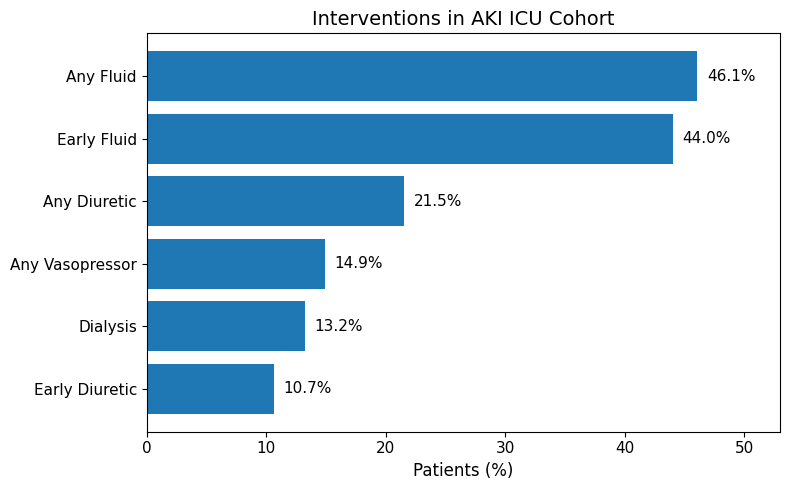

In [9]:
cols = [
    "dialysis",
    "any_vasopressor",
    "early_fluid",
    "any_fluid",
    "early_diuretic",
    "any_diuretic",
]

fig = plot_interventions(
    df,
    cols,
    title="Interventions in AKI ICU Cohort"
)
plt.show()


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_mortality_by_intervention(
    df,
    interventions,
    mortality_col="hospital_mortality",
    figsize=(9, 5),
    title="Hospital Mortality by Intervention Status"
):
    rows = []

    for c in interventions:
        if c not in df.columns:
            continue

        for val, label in [(1, "Yes"), (0, "No")]:
            sub = df[df[c] == val]
            if len(sub) == 0:
                continue

            mort = pd.to_numeric(sub[mortality_col], errors="coerce")
            rows.append({
                "Intervention": c.replace("_", " ").title(),
                "Group": label,
                "Mortality": 100 * mort.mean(),
                "N": len(sub),
            })

    plot_df = pd.DataFrame(rows)

    # Order by mortality in YES group
    order = (
        plot_df[plot_df["Group"] == "Yes"]
        .sort_values("Mortality")["Intervention"]
    )

    fig, ax = plt.subplots(figsize=figsize)

    y = np.arange(len(order))
    width = 0.35

    yes = plot_df[plot_df["Group"] == "Yes"].set_index("Intervention").loc[order]
    no  = plot_df[plot_df["Group"] == "No"].set_index("Intervention").loc[order]

    ax.barh(y - width/2, no["Mortality"], height=width, label="No")
    ax.barh(y + width/2, yes["Mortality"], height=width, label="Yes")

    # --- Labels: % and n
    for i, name in enumerate(order):
        ax.text(
            no.loc[name, "Mortality"] + 0.6,
            i - width/2,
            f'{no.loc[name, "Mortality"]:.1f}%  (n={no.loc[name, "N"]})',
            va="center",
            fontsize=10
        )
        ax.text(
            yes.loc[name, "Mortality"] + 0.6,
            i + width/2,
            f'{yes.loc[name, "Mortality"]:.1f}%  (n={yes.loc[name, "N"]})',
            va="center",
            fontsize=10
        )

    ax.set_yticks(y)
    ax.set_yticklabels(order, fontsize=11)
    ax.set_xlabel("Hospital Mortality (%)", fontsize=12)
    ax.set_title(title, fontsize=14)

    ax.legend(frameon=False)
    ax.set_xlim(0, max(plot_df["Mortality"]) * 1.25)

    plt.tight_layout()
    return fig


In [21]:
df["early_vasopressor"] = (
    (df["early_norepinephrine"] == 1) |
    (df["early_epinephrine"] == 1) |
    (df["early_phenylephrine"] == 1)
).astype(int)
(df["early_vasopressor"] == df["any_vasopressor"]).all()


np.True_

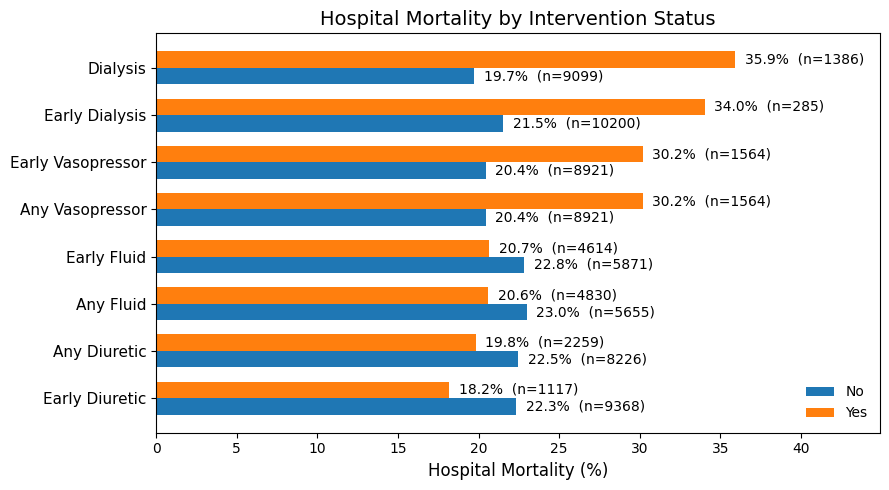

In [22]:
interventions = [
    "dialysis",
    "early_dialysis",
    "any_vasopressor",
    "early_vasopressor",
    "any_fluid",
    "early_fluid",
    "any_diuretic",
    "early_diuretic",

]

fig = plot_mortality_by_intervention(
    df,
    interventions,
    mortality_col="hospital_mortality",
    title="Hospital Mortality by Intervention Status"
)

plt.show()


In [25]:
import pandas as pd
import numpy as np
from src.db import q

def first_intervention_timing(
    df,
    patterns,
    label,
):
    """
    Adds two columns:
      - first_<label>_hours
      - first_<label>_timing  ∈ {0–12 h, 12–24 h, >24 h, No intervention}
    """

    where = " OR ".join([f"LOWER(di.label) LIKE '{p}'" for p in patterns])

    ev = q(f"""
        SELECT ie.icustay_id, ie.starttime
        FROM inputevents_mv ie
        JOIN d_items di ON ie.itemid = di.itemid
        WHERE {where}
    """)

    ev = ev.merge(
        df[["icustay_id", "intime"]],
        on="icustay_id",
        how="inner"
    ).dropna(subset=["starttime", "intime"])

    ev["hours_since_icu"] = (
        ev["starttime"] - ev["intime"]
    ).dt.total_seconds() / 3600

    ev = ev[ev["hours_since_icu"] >= 0]

    first_ev = (
        ev.sort_values(["icustay_id", "hours_since_icu"])
          .groupby("icustay_id", as_index=False)
          .first()[["icustay_id", "hours_since_icu"]]
    )

    out = df.merge(first_ev, on="icustay_id", how="left")

    timing_col = f"first_{label}_timing"
    hours_col = f"first_{label}_hours"

    out[hours_col] = out["hours_since_icu"]

    out[timing_col] = np.select(
        [
            out[hours_col].between(0, 12, inclusive="left"),
            out[hours_col].between(12, 24, inclusive="left"),
            out[hours_col] > 24,
            out[hours_col].isna(),
        ],
        [
            "0–12 h",
            "12–24 h",
            ">24 h",
            "No intervention",
        ],
        default="Other",
    )

    out[timing_col] = pd.Categorical(
        out[timing_col],
        categories=["0–12 h", "12–24 h", ">24 h", "No intervention"],
        ordered=True
    )

    return out.drop(columns=["hours_since_icu"])


In [26]:
VASO_PATTERNS = [
    "%norepinephrine%", "%epinephrine%",
    "%phenylephrine%", "%vasopressin%",
]

FLUID_PATTERNS = [
    "%normal saline%", "%0.9%saline%", "%saline%",
    "%lactated ring%", "%ringer%",
    "%plasmalyte%", "%plasma-lyte%",
    "%d5w%", "%dextrose%",
    "%albumin%",
    "%packed red%", "%prbc%", "%red blood cell%",
    "%fresh frozen plasma%", "%ffp%",
    "%platelet%",
]

DIURETIC_PATTERNS = [
    "%furosemide%", "%lasix%",
    "%bumetanide%", "%torsemide%",
    "%chlorothiazide%", "%metolazone%",
    "%mannitol%", "%acetazolamide%",
]


In [27]:
df3 = df.copy()

df3 = first_intervention_timing(df3, VASO_PATTERNS, "vaso")
df3 = first_intervention_timing(df3, FLUID_PATTERNS, "fluid")
df3 = first_intervention_timing(df3, DIURETIC_PATTERNS, "diuretic")


In [28]:
def mortality_by_timing(df, timing_col, mortality_col="hospital_mortality"):
    out = (
        df
        .groupby(timing_col)
        .agg(
            n=(mortality_col, "size"),
            mortality_pct=(mortality_col, "mean"),
        )
        .reset_index()
    )
    out["mortality_pct"] *= 100
    return out


In [29]:
mort_vaso = mortality_by_timing(df3, "first_vaso_timing")
mort_fluid = mortality_by_timing(df3, "first_fluid_timing")
mort_diur = mortality_by_timing(df3, "first_diuretic_timing")

mort_vaso, mort_fluid, mort_diur


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2454756539.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2454756539.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2454756539.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


(  first_vaso_timing     n  mortality_pct
 0            0–12 h  1419      29.668781
 1           12–24 h   148      35.135135
 2             >24 h   376      49.734043
 3   No intervention  8542      19.140716,
   first_fluid_timing     n  mortality_pct
 0             0–12 h  4291      21.090655
 1            12–24 h   323      15.170279
 2              >24 h   214      19.158879
 3    No intervention  5657      22.980378,
   first_diuretic_timing     n  mortality_pct
 0                0–12 h   690      19.710145
 1               12–24 h   427      15.690867
 2                 >24 h  1142      21.453590
 3       No intervention  8226      22.453197)

In [30]:
import matplotlib.pyplot as plt

def plot_combined_mortality_by_timing(
    df,
    timing_cols,
    titles,
    mortality_col="hospital_mortality",
    figsize=(12, 4),
):
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)

    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    for ax, timing_col, title in zip(axes, timing_cols, titles):
        tmp = (
            df
            .groupby(timing_col)
            .agg(
                n=(mortality_col, "size"),
                mort=(mortality_col, "mean"),
            )
            .reindex(order)
            .reset_index()
        )

        tmp["mort"] *= 100

        ax.bar(
            tmp[timing_col],
            tmp["mort"]
        )

        for i, row in tmp.iterrows():
            if pd.isna(row["mort"]):
                continue
            ax.text(
                i,
                row["mort"] + 0.8,
                f'{row["mort"]:.1f}%\n(n={int(row["n"])})',
                ha="center",
                va="bottom",
                fontsize=11
            )

        ax.set_title(title, fontsize=13)
        ax.set_xlabel("Timing of first intervention", fontsize=11)
        ax.tick_params(axis="x", labelrotation=0, labelsize=11)

    axes[0].set_ylabel("Hospital Mortality (%)", fontsize=12)
    axes[0].set_ylim(0, df[mortality_col].mean() * 200)

    fig.suptitle(
        "Hospital Mortality by Timing of First Intervention",
        fontsize=15,
        y=1.05
    )

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1303331525.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1303331525.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1303331525.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


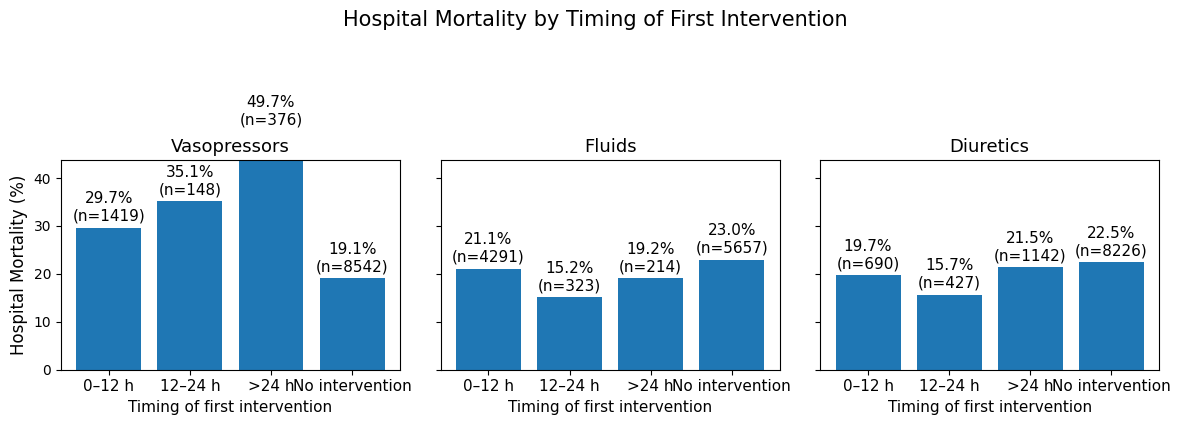

In [31]:
fig = plot_combined_mortality_by_timing(
    df3,
    timing_cols=[
        "first_vaso_timing",
        "first_fluid_timing",
        "first_diuretic_timing",
    ],
    titles=[
        "Vasopressors",
        "Fluids",
        "Diuretics",
    ],
)

plt.show()


In [32]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_mortality_by_timing_single(
    df,
    timing_col,
    title,
    mortality_col="hospital_mortality",
    colors=None,
    figsize=(4.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    if colors is None:
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#7f7f7f"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=(mortality_col, "size"),
            mort=(mortality_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["mort"] *= 100

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(
        tmp[timing_col],
        tmp["mort"],
        color=colors
    )

    for i, row in tmp.iterrows():
        if pd.isna(row["mort"]):
            continue
        ax.text(
            i,
            row["mort"] + 0.8,
            f'{row["mort"]:.1f}%\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=11
        )

    ax.set_ylabel("Hospital Mortality (%)", fontsize=12)
    ax.set_xlabel("Timing of first intervention", fontsize=11)
    ax.set_title(title, fontsize=14)

    ax.set_ylim(0, max(tmp["mort"].max() * 1.25, 5))
    ax.tick_params(axis="x", labelsize=11)

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\586205683.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


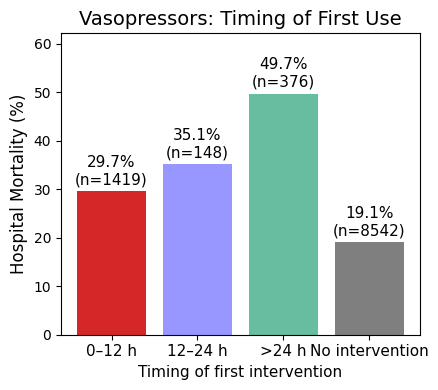

In [34]:
fig_vaso = plot_mortality_by_timing_single(
    df3,
    timing_col="first_vaso_timing",
    title="Vasopressors: Timing of First Use",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\586205683.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


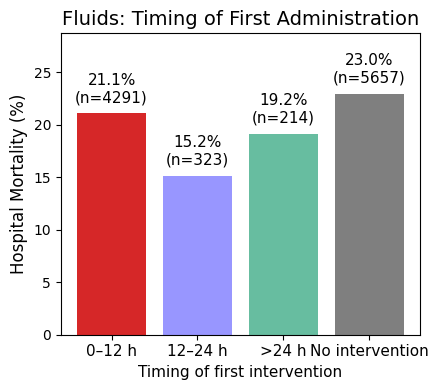

In [36]:
fig_fluid = plot_mortality_by_timing_single(
    df3,
    timing_col="first_fluid_timing",
    title="Fluids: Timing of First Administration",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\586205683.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


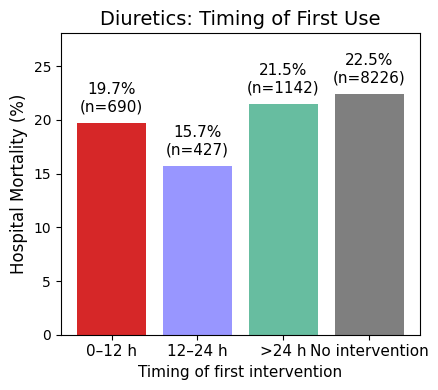

In [38]:
fig_diur = plot_mortality_by_timing_single(
    df3,
    timing_col="first_diuretic_timing",
    title="Diuretics: Timing of First Use",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
    
)

plt.show()


In [39]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_rrt_persistence_by_timing_single(
    df,
    timing_col,
    title,
    outcome_col="rrt_persistent_last6h",
    colors=None,
    figsize=(4.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    if colors is None:
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#7f7f7f"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=(outcome_col, "size"),
            rate=(outcome_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["rate"] *= 100

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(
        tmp[timing_col],
        tmp["rate"],
        color=colors
    )

    for i, row in tmp.iterrows():
        if pd.isna(row["rate"]):
            continue
        ax.text(
            i,
            row["rate"] + 0.8,
            f'{row["rate"]:.1f}%\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=11
        )

    ax.set_ylabel("Persistent RRT at ICU Discharge (%)", fontsize=12)
    ax.set_xlabel("Timing of first intervention", fontsize=11)
    ax.set_title(title, fontsize=14)

    ax.set_ylim(0, max(tmp["rate"].max() * 1.25, 5))
    ax.tick_params(axis="x", labelsize=11)

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\448871382.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


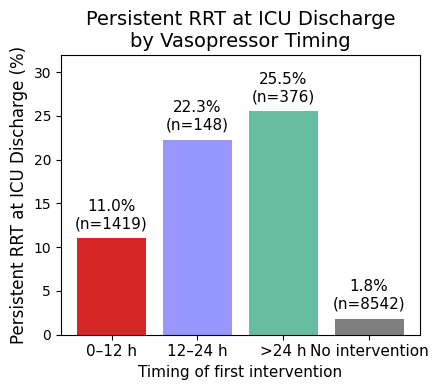

In [44]:
fig_vaso_rrt = plot_rrt_persistence_by_timing_single(
    df3,
    timing_col="first_vaso_timing",
    title="Persistent RRT at ICU Discharge\nby Vasopressor Timing",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\448871382.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


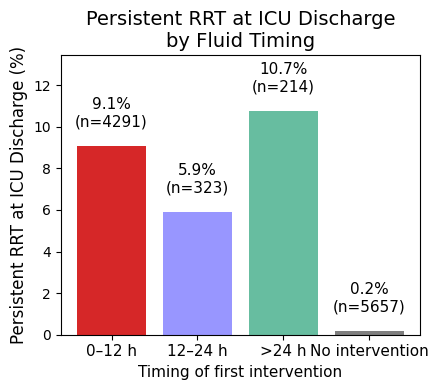

In [45]:
fig_fluid_rrt = plot_rrt_persistence_by_timing_single(
    df3,
    timing_col="first_fluid_timing",
    title="Persistent RRT at ICU Discharge\nby Fluid Timing",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\448871382.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


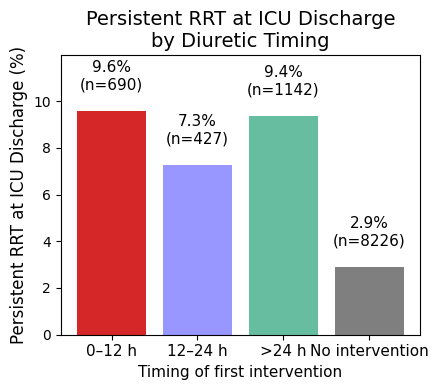

In [47]:
fig_diur_rrt = plot_rrt_persistence_by_timing_single(
    df3,
    timing_col="first_diuretic_timing",
    title="Persistent RRT at ICU Discharge\nby Diuretic Timing",
    colors=["#d62728", "#9896ff", "#67bda0", "#7f7f7f"],
)

plt.show()


In [51]:
import pandas as pd

def score_summary_by_timing(
    df,
    timing_col,
):
    out = (
        df
        .groupby(timing_col)
        .agg(
            n=("icustay_id", "size"),
            sofa_mean=("sofa", "mean"),
            sofa_sd=("sofa", "std"),
            sofa_renal_mean=("sofa_renal", "mean"),
            sofa_renal_sd=("sofa_renal", "std"),
            sapsii_mean=("sapsii", "mean"),
            sapsii_sd=("sapsii", "std"),
        )
        .reset_index()
    )

    out["SOFA total (mean ± SD)"] = out.apply(
        lambda r: f"{r['sofa_mean']:.1f} ± {r['sofa_sd']:.1f}", axis=1
    )
    out["SOFA renal (mean ± SD)"] = out.apply(
        lambda r: f"{r['sofa_renal_mean']:.1f} ± {r['sofa_renal_sd']:.1f}", axis=1
    )
    out["SAPS II (mean ± SD)"] = out.apply(
        lambda r: f"{r['sapsii_mean']:.1f} ± {r['sapsii_sd']:.1f}", axis=1
    )

    return out[
        [
            timing_col,
            "n",
            "SOFA total (mean ± SD)",
            "SOFA renal (mean ± SD)",
            "SAPS II (mean ± SD)",
        ]
    ]


In [52]:
scores_vaso = score_summary_by_timing(df3, "first_vaso_timing")
scores_fluid = score_summary_by_timing(df3, "first_fluid_timing")
scores_diur = score_summary_by_timing(df3, "first_diuretic_timing")

scores_vaso, scores_fluid, scores_diur



C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1783744738.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1783744738.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1783744738.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


(  first_vaso_timing     n SOFA total (mean ± SD) SOFA renal (mean ± SD)  \
 0            0–12 h  1419              9.0 ± 3.9              1.9 ± 1.3   
 1           12–24 h   148              9.2 ± 3.7              2.0 ± 1.4   
 2             >24 h   376              6.1 ± 3.3              1.6 ± 1.3   
 3   No intervention  8542              5.5 ± 3.3              1.7 ± 1.2   
 
   SAPS II (mean ± SD)  
 0         51.2 ± 16.2  
 1         53.6 ± 13.9  
 2         44.0 ± 13.9  
 3         41.1 ± 14.3  ,
   first_fluid_timing     n SOFA total (mean ± SD) SOFA renal (mean ± SD)  \
 0             0–12 h  4291              6.5 ± 3.8              1.7 ± 1.2   
 1            12–24 h   323              5.3 ± 2.9              1.7 ± 1.1   
 2              >24 h   214              4.8 ± 2.5              1.6 ± 1.2   
 3    No intervention  5657              5.9 ± 3.6              1.8 ± 1.2   
 
   SAPS II (mean ± SD)  
 0         43.8 ± 15.3  
 1         41.1 ± 13.0  
 2         38.4 ± 12.4  
 3   

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scores_by_timing(
    df,
    timing_col,
    title,
    figsize=(6.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=("icustay_id", "size"),
            sofa=("sofa", "mean"),
            sofa_renal=("sofa_renal", "mean"),
            sapsii=("sapsii", "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    x = np.arange(len(order))
    width = 0.25

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(x - width, tmp["sofa"], width, label="SOFA total")
    ax.bar(x,         tmp["sofa_renal"], width, label="SOFA renal")
    ax.bar(x + width, tmp["sapsii"], width, label="SAPS II")

    for i, row in tmp.iterrows():
        ax.text(
            x[i],
            max(row["sofa"], row["sofa_renal"], row["sapsii"]) + 0.8,
            f"n={int(row['n'])}",
            ha="center",
            fontsize=10
        )

    ax.set_xticks(x)
    ax.set_xticklabels(order, fontsize=11)
    ax.set_ylabel("Mean score", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(frameon=False)

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\4245607479.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\4245607479.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\4245607479.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


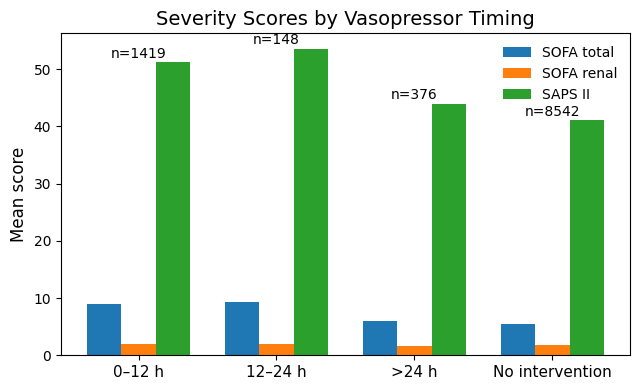

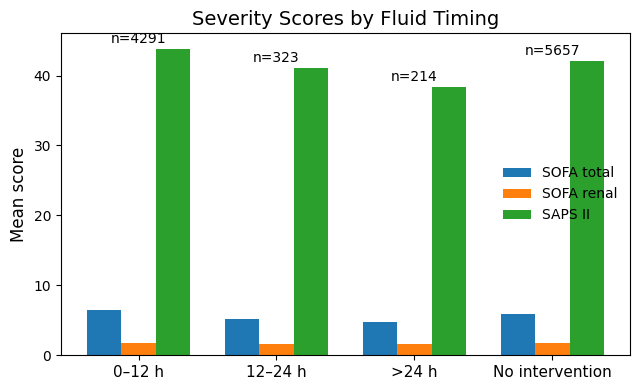

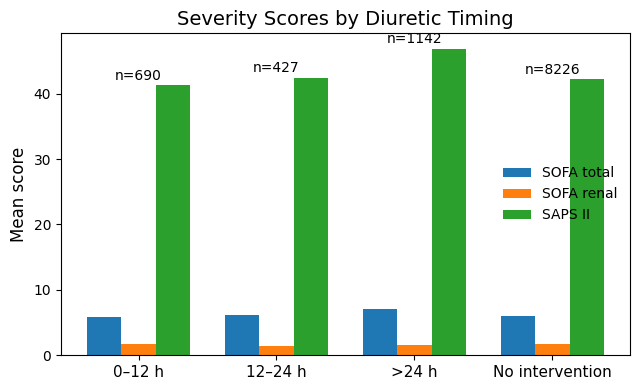

In [54]:
fig_vaso_scores = plot_scores_by_timing(
    df3,
    "first_vaso_timing",
    "Severity Scores by Vasopressor Timing",
)

fig_fluid_scores = plot_scores_by_timing(
    df3,
    "first_fluid_timing",
    "Severity Scores by Fluid Timing",
)

fig_diur_scores = plot_scores_by_timing(
    df3,
    "first_diuretic_timing",
    "Severity Scores by Diuretic Timing",
)

plt.show()


In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_score_by_timing(
    df,
    timing_col,
    score_col,
    title,
    ylabel,
    color="#1f77b4",
    figsize=(4.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=("icustay_id", "size"),
            mean_score=(score_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(
        tmp[timing_col],
        tmp["mean_score"],
        color=color,
    )

    for i, row in tmp.iterrows():
        if pd.isna(row["mean_score"]):
            continue
        ax.text(
            i,
            row["mean_score"] + 0.5,
            f'{row["mean_score"]:.1f}\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=11
        )

    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel("Timing of first intervention", fontsize=11)
    ax.tick_params(axis="x", labelsize=11)

    ax.set_ylim(0, max(tmp["mean_score"].max() * 1.25, 3))
    plt.tight_layout()
    return fig


In [56]:
def plot_mortality_by_timing(
    df,
    timing_col,
    title,
    mortality_col="hospital_mortality",
    color="#d62728",
    figsize=(4.5, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=(mortality_col, "size"),
            mort=(mortality_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["mort"] *= 100

    fig, ax = plt.subplots(figsize=figsize)

    ax.bar(
        tmp[timing_col],
        tmp["mort"],
        color=color,
    )

    for i, row in tmp.iterrows():
        if pd.isna(row["mort"]):
            continue
        ax.text(
            i,
            row["mort"] + 0.8,
            f'{row["mort"]:.1f}%\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=11
        )

    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Hospital Mortality (%)", fontsize=12)
    ax.set_xlabel("Timing of first intervention", fontsize=11)
    ax.tick_params(axis="x", labelsize=11)

    ax.set_ylim(0, max(tmp["mort"].max() * 1.25, 5))
    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2917335501.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2917335501.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2917335501.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)
C:\Users\Simon\AppD

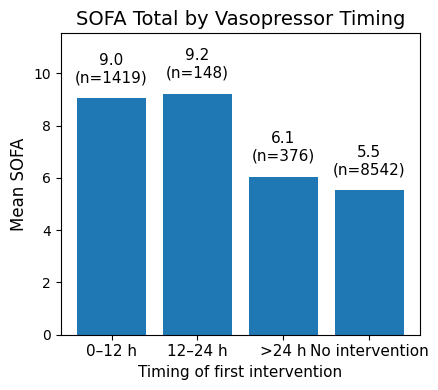

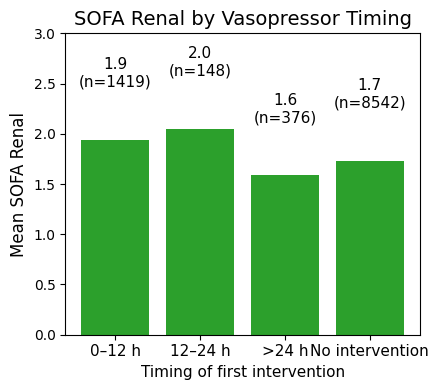

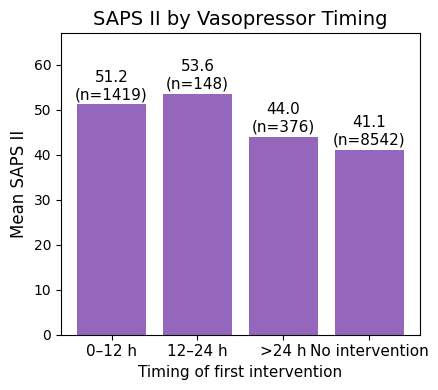

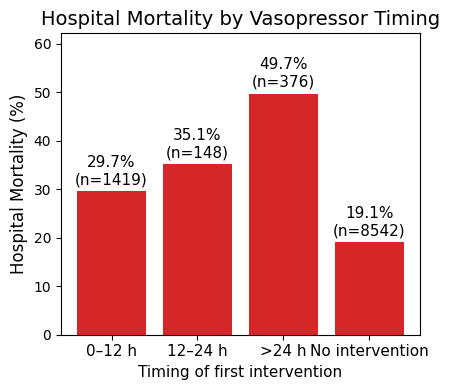

In [57]:
fig_sofa_vaso = plot_score_by_timing(
    df3,
    "first_vaso_timing",
    score_col="sofa",
    title="SOFA Total by Vasopressor Timing",
    ylabel="Mean SOFA",
    color="#1f77b4",
)

fig_sofa_renal_vaso = plot_score_by_timing(
    df3,
    "first_vaso_timing",
    score_col="sofa_renal",
    title="SOFA Renal by Vasopressor Timing",
    ylabel="Mean SOFA Renal",
    color="#2ca02c",
)

fig_saps_vaso = plot_score_by_timing(
    df3,
    "first_vaso_timing",
    score_col="sapsii",
    title="SAPS II by Vasopressor Timing",
    ylabel="Mean SAPS II",
    color="#9467bd",
)

fig_mort_vaso = plot_mortality_by_timing(
    df3,
    "first_vaso_timing",
    title="Hospital Mortality by Vasopressor Timing",
)

plt.show()


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_score_with_mortality_overlay(
    df,
    timing_col,
    score_col,
    mortality_col="hospital_mortality",
    title="",
    score_ylabel="Mean score",
    mort_ylabel="Hospital mortality (%)",
    score_color="#1f77b4",
    mort_color="#d62728",
    figsize=(5.2, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=("icustay_id", "size"),
            score_mean=(score_col, "mean"),
            mort_mean=(mortality_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["mort_pct"] = tmp["mort_mean"] * 100

    x = np.arange(len(order))

    fig, ax1 = plt.subplots(figsize=figsize)

    # Bars = score
    ax1.bar(x, tmp["score_mean"], color=score_color, alpha=0.9)
    ax1.set_ylabel(score_ylabel, fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(order, fontsize=11)
    ax1.set_title(title, fontsize=14)

    # annotate score + n
    for i, row in tmp.iterrows():
        if pd.isna(row["score_mean"]):
            continue
        ax1.text(
            i,
            row["score_mean"] + (0.03 * tmp["score_mean"].max() if tmp["score_mean"].max() > 0 else 0.2),
            f'{row["score_mean"]:.1f}\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=10
        )

    ax1.set_ylim(0, max(tmp["score_mean"].max() * 1.25, 1))

    # Line = mortality on secondary axis
    ax2 = ax1.twinx()
    ax2.plot(x, tmp["mort_pct"], color=mort_color, marker="o", linewidth=2.5)
    ax2.set_ylabel(mort_ylabel, fontsize=12)

    for i, row in tmp.iterrows():
        if pd.isna(row["mort_pct"]):
            continue
        ax2.text(
            i,
            row["mort_pct"] + 0.8,
            f'{row["mort_pct"]:.1f}%',
            ha="center",
            va="bottom",
            fontsize=10,
            color=mort_color
        )

    ax2.set_ylim(0, max(tmp["mort_pct"].max() * 1.35, 5))

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


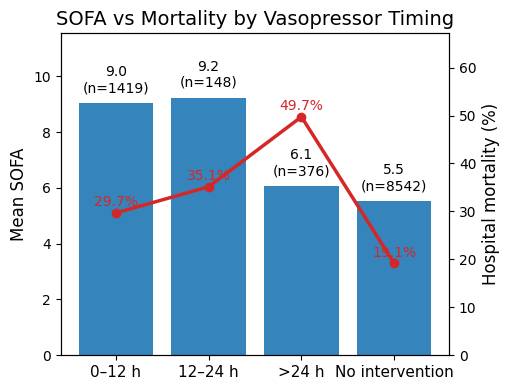

In [59]:
fig = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sofa",
    title="SOFA vs Mortality by Vasopressor Timing",
    score_ylabel="Mean SOFA",
    mort_ylabel="Hospital mortality (%)",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


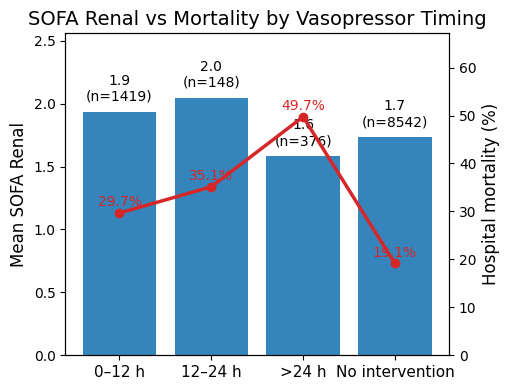

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


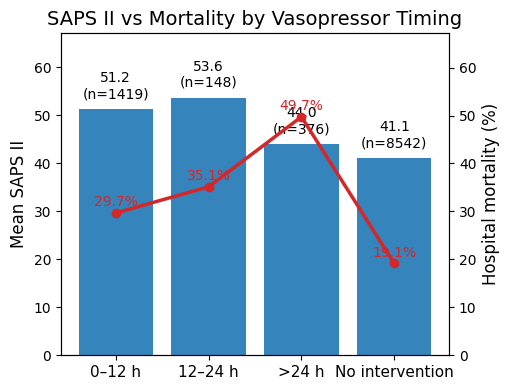

In [74]:
fig_sofa_renal = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Mortality by Vasopressor Timing",
    score_ylabel="Mean SOFA Renal",
    mort_ylabel="Hospital mortality (%)",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()

fig_saps = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sapsii",
    title="SAPS II vs Mortality by Vasopressor Timing",
    score_ylabel="Mean SAPS II",
    mort_ylabel="Hospital mortality (%)",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


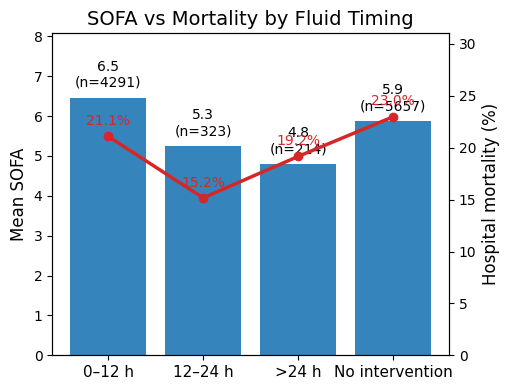

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


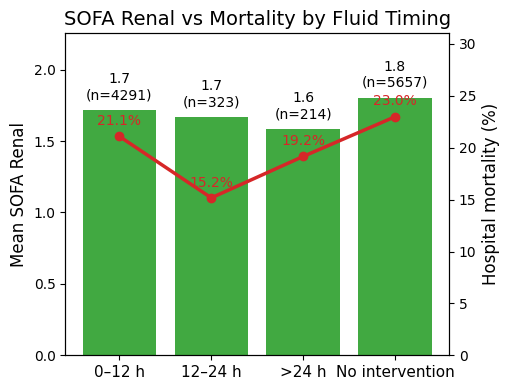

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


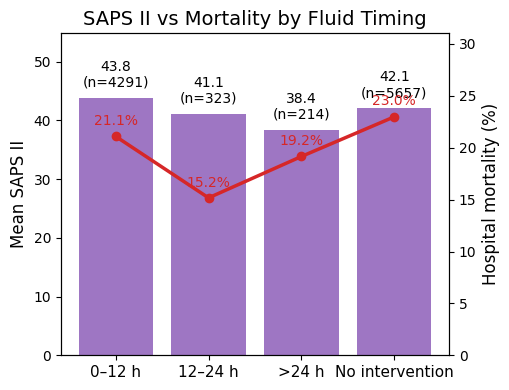

In [ ]:
# Fluids — SOFA total + mortality
fig_fluid_sofa = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sofa",
    title="SOFA vs Mortality by Fluid Timing",
    score_ylabel="Mean SOFA",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()

# Fluids — SOFA renal + mortality
fig_fluid_renal = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Mortality by Fluid Timing",
    score_ylabel="Mean SOFA Renal",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()

# Fluids — SAPS II + mortality
fig_fluid_saps = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sapsii",
    title="SAPS II vs Mortality by Fluid Timing",
    score_ylabel="Mean SAPS II",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


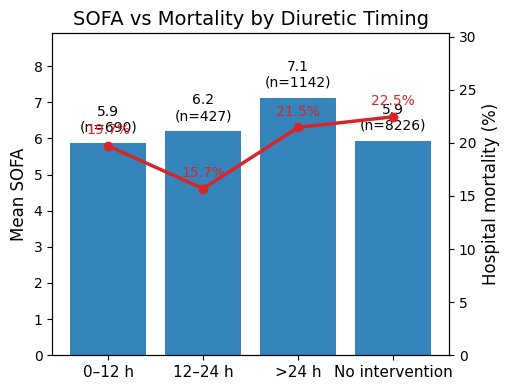

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


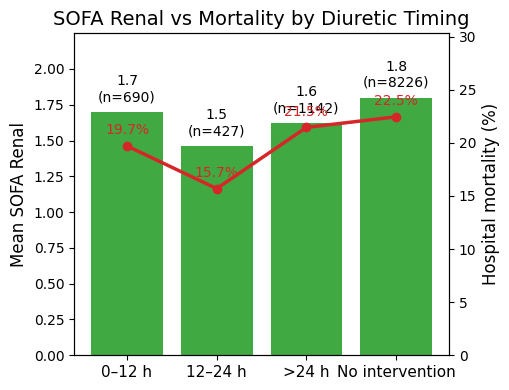

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\28006260.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


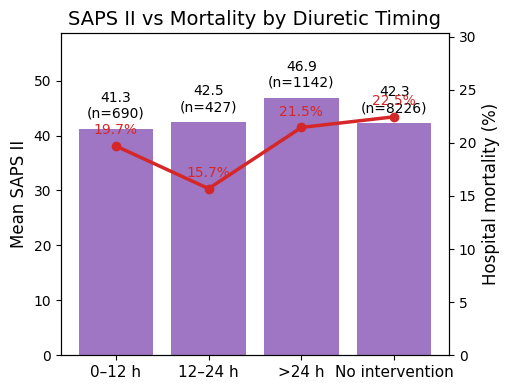

In [ ]:
# Diuretics — SOFA total + mortality
fig_diur_sofa = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sofa",
    title="SOFA vs Mortality by Diuretic Timing",
    score_ylabel="Mean SOFA",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()

# Diuretics — SOFA renal + mortality
fig_diur_renal = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Mortality by Diuretic Timing",
    score_ylabel="Mean SOFA Renal",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()

# Diuretics — SAPS II + mortality
fig_diur_saps = plot_score_with_mortality_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sapsii",
    title="SAPS II vs Mortality by Diuretic Timing",
    score_ylabel="Mean SAPS II",
    score_color="#1f77b4",
    mort_color="#d62728",
)
plt.show()


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_score_with_rrt_overlay(
    df,
    timing_col,
    score_col,
    outcome_col="rrt_persistent_last6h",
    title="",
    score_ylabel="Mean score",
    rrt_ylabel="Persistent RRT at ICU discharge (%)",
    score_color="#1f77b4",
    rrt_color="#d01515",
    figsize=(5.2, 4),
):
    order = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    tmp = (
        df
        .groupby(timing_col)
        .agg(
            n=("icustay_id", "size"),
            score_mean=(score_col, "mean"),
            rrt_mean=(outcome_col, "mean"),
        )
        .reindex(order)
        .reset_index()
    )

    tmp["rrt_pct"] = tmp["rrt_mean"] * 100
    x = np.arange(len(order))

    fig, ax1 = plt.subplots(figsize=figsize)

    # --- Bars: score
    ax1.bar(x, tmp["score_mean"], color=score_color, alpha=0.9)
    ax1.set_ylabel(score_ylabel, fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(order, fontsize=11)
    ax1.set_title(title, fontsize=14)

    for i, row in tmp.iterrows():
        if pd.isna(row["score_mean"]):
            continue
        ax1.text(
            i,
            row["score_mean"] + max(tmp["score_mean"].max() * 0.03, 0.2),
            f'{row["score_mean"]:.1f}\n(n={int(row["n"])})',
            ha="center",
            va="bottom",
            fontsize=10
        )

    ax1.set_ylim(0, max(tmp["score_mean"].max() * 1.25, 1))

    # --- Line: RRT persistence
    ax2 = ax1.twinx()
    ax2.plot(
        x,
        tmp["rrt_pct"],
        color=rrt_color,
        marker="o",
        linewidth=2.5
    )
    ax2.set_ylabel(rrt_ylabel, fontsize=12)

    for i, row in tmp.iterrows():
        if pd.isna(row["rrt_pct"]):
            continue
        ax2.text(
            i,
            row["rrt_pct"] + 0.8,
            f'{row["rrt_pct"]:.1f}%',
            ha="center",
            va="bottom",
            fontsize=10,
            color=rrt_color
        )

    ax2.set_ylim(0, max(tmp["rrt_pct"].max() * 1.35, 5))

    plt.tight_layout()
    return fig


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


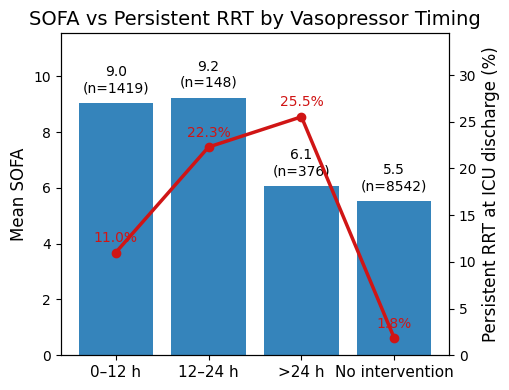

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


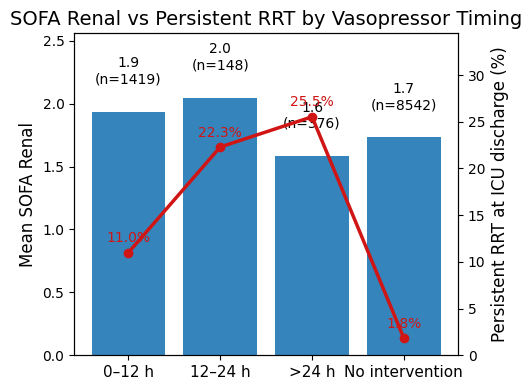

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


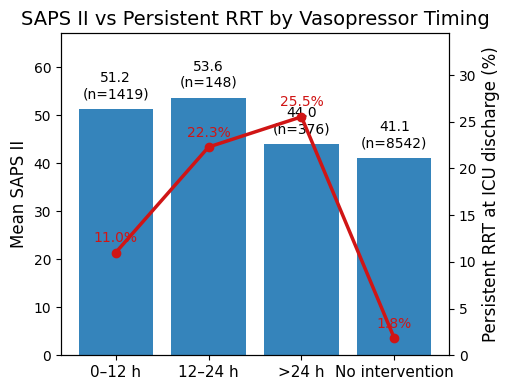

In [71]:
# SOFA total
plot_score_with_rrt_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sofa",
    title="SOFA vs Persistent RRT by Vasopressor Timing",
    score_ylabel="Mean SOFA",
    score_color="#1f77b4",
); plt.show()

# SOFA renal
plot_score_with_rrt_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Persistent RRT by Vasopressor Timing",
    score_ylabel="Mean SOFA Renal",
    score_color="#1f77b4",
); plt.show()

# SAPS II
plot_score_with_rrt_overlay(
    df3,
    timing_col="first_vaso_timing",
    score_col="sapsii",
    title="SAPS II vs Persistent RRT by Vasopressor Timing",
    score_ylabel="Mean SAPS II",
    score_color="#1f77b4", 
); plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


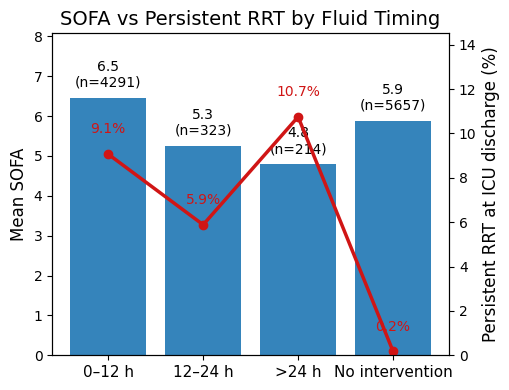

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


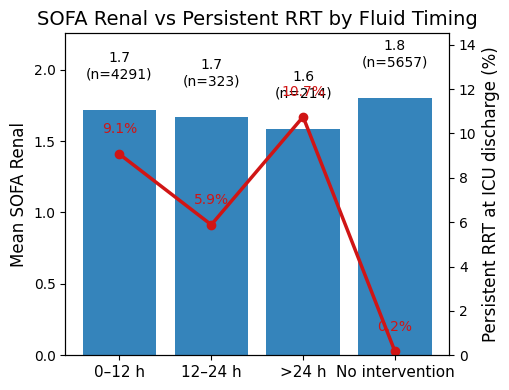

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


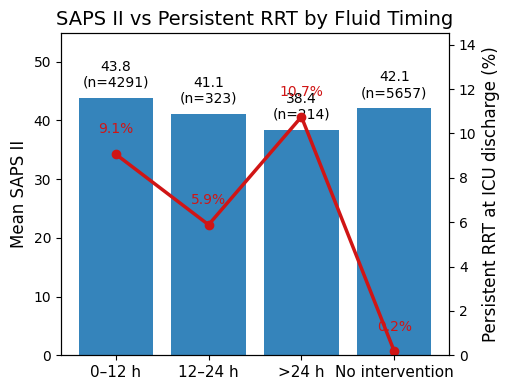

In [72]:
plot_score_with_rrt_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sofa",
    title="SOFA vs Persistent RRT by Fluid Timing",
    score_ylabel="Mean SOFA",
    score_color="#1f77b4",
); plt.show()

plot_score_with_rrt_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Persistent RRT by Fluid Timing",
    score_ylabel="Mean SOFA Renal",
    score_color="#1f77b4",
); plt.show()

plot_score_with_rrt_overlay(
    df3,
    timing_col="first_fluid_timing",
    score_col="sapsii",
    title="SAPS II vs Persistent RRT by Fluid Timing",
    score_ylabel="Mean SAPS II",
    score_color="#1f77b4",
); plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


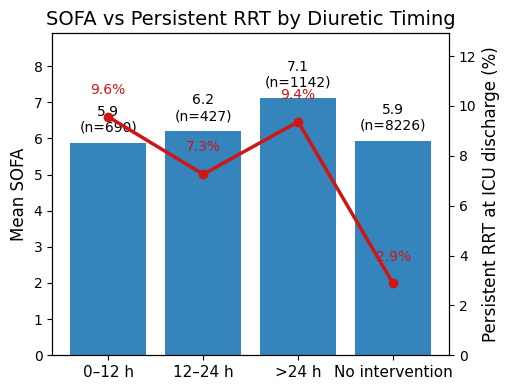

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


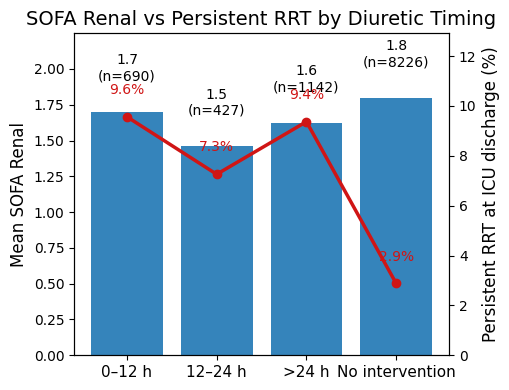

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\2149612300.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(timing_col)


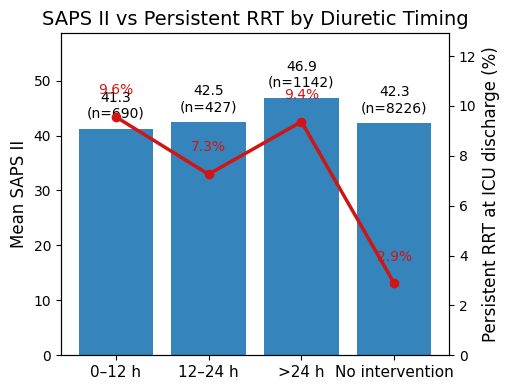

In [73]:
plot_score_with_rrt_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sofa",
    title="SOFA vs Persistent RRT by Diuretic Timing",
    score_ylabel="Mean SOFA",
    score_color="#1f77b4",
); plt.show()

plot_score_with_rrt_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sofa_renal",
    title="SOFA Renal vs Persistent RRT by Diuretic Timing",
    score_ylabel="Mean SOFA Renal",
    score_color="#1f77b4",
); plt.show()

plot_score_with_rrt_overlay(
    df3,
    timing_col="first_diuretic_timing",
    score_col="sapsii",
    title="SAPS II vs Persistent RRT by Diuretic Timing",
    score_ylabel="Mean SAPS II",
    score_color="#1f77b4",
); plt.show()


In [75]:
import pandas as pd
import numpy as np

def add_score_bins(df, score_col, n_bins=4, prefix=None):
    out = df.copy()
    if prefix is None:
        prefix = score_col

    # Quartile (robust, gleich große Gruppen)
    out[f"{prefix}_bin"] = pd.qcut(out[score_col], q=n_bins, duplicates="drop")
    return out

def hours_to_timing_group(hours_series):
    return pd.Categorical(
        np.select(
            [
                hours_series.between(0, 12, inclusive="left"),
                hours_series.between(12, 24, inclusive="left"),
                hours_series > 24,
                hours_series.isna(),
            ],
            ["0–12 h", "12–24 h", ">24 h", "No intervention"],
            default="Other",
        ),
        categories=["0–12 h", "12–24 h", ">24 h", "No intervention"],
        ordered=True
    )

# falls du nur *_timing hast, kannst du diesen Schritt überspringen
df4 = df3.copy()
df4["vaso_timing"] = hours_to_timing_group(df4.get("first_vaso_hours", np.nan))
df4["fluid_timing"] = hours_to_timing_group(df4.get("first_fluid_hours", np.nan))
df4["diuretic_timing"] = hours_to_timing_group(df4.get("first_diuretic_hours", np.nan))

# Score bins (Quartile) – du kannst auch n_bins=5 machen etc.
df4 = add_score_bins(df4, "sofa", n_bins=4, prefix="sofa")
df4 = add_score_bins(df4, "sofa_renal", n_bins=4, prefix="sofa_renal")
df4 = add_score_bins(df4, "sapsii", n_bins=4, prefix="sapsii")


In [76]:
def score_group_timing_stats(df, score_bin_col, timing_col, outcome_col="hospital_mortality"):
    # n und mortality pro Bin×Timing
    agg = (
        df.groupby([score_bin_col, timing_col])
          .agg(n=("icustay_id", "size"),
               mortality=(outcome_col, "mean"))
          .reset_index()
    )
    agg["mortality_pct"] = agg["mortality"] * 100

    # Timing-Verteilung innerhalb jedes Score-Bins
    agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")
    agg["within_bin_pct"] = 100 * agg["n"] / agg["bin_total"]
    return agg

stats_sofa_vaso = score_group_timing_stats(df4, "sofa_bin", "vaso_timing")
stats_sofa_fluid = score_group_timing_stats(df4, "sofa_bin", "fluid_timing")
stats_sofa_diur = score_group_timing_stats(df4, "sofa_bin", "diuretic_timing")

stats_sofa_vaso.head()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and 

,sofa_bin,vaso_timing,n,mortality,mortality_pct,bin_total,within_bin_pct
0,"(-0.001, 3.0]",0–12 h,76,0.105263,10.526316,2870,2.648084
1,"(-0.001, 3.0]",12–24 h,6,0.000000,0.000000,2870,0.209059
2,"(-0.001, 3.0]",>24 h,101,0.415842,41.584158,2870,3.519164
3,"(-0.001, 3.0]",No intervention,2687,0.086342,8.634164,2870,93.623693
4,"(3.0, 5.0]",0–12 h,183,0.131148,13.114754,2449,7.472438


In [85]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mortality_by_timing_within_score_bins(stats_df, score_bin_col, timing_col, title, figsize=(10, 4.5)):
    order_timing = ["0–12 h", "12–24 h", ">24 h", "No intervention"]

    bins = list(stats_df[score_bin_col].dropna().unique())
    bins = sorted(bins, key=lambda x: str(x))

    fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(len(bins))
    width = 0.2
    offsets = {"0–12 h": -1.5*width, "12–24 h": -0.5*width, ">24 h": 0.5*width, "No intervention": 1.5*width}

    for t in order_timing:
        sub = stats_df[stats_df[timing_col] == t].set_index(score_bin_col).reindex(bins)
        y = sub["mortality_pct"].values
        n = sub["n"].fillna(0).astype(int).values

        ax.bar(x + offsets[t], y, width, label=t)

        for i in range(len(bins)):
            if np.isnan(y[i]):
                continue
            # ax.text(x[i] + offsets[t], y[i] + 0.6, f"n={n[i]}", ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x)
    labels = []
    for b in bins:
        n_bin = stats_df.loc[stats_df[score_bin_col] == b, "n"].sum()
        labels.append(f"{b}\n(n={int(n_bin)})")

    ax.set_xticklabels(labels, rotation=0, fontsize=10)
    ax.set_ylabel("Hospital mortality (%)", fontsize=12)
    ax.set_xlabel("Score group (quantiles)", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(frameon=False, ncol=4)
    ax.set_ylim(0, max(stats_df["mortality_pct"].max() * 1.25, 5))

    plt.tight_layout()
    return fig


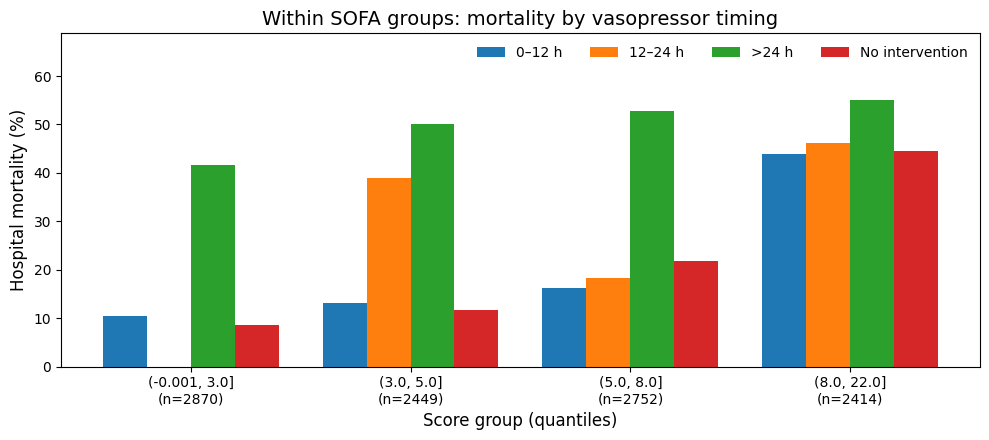

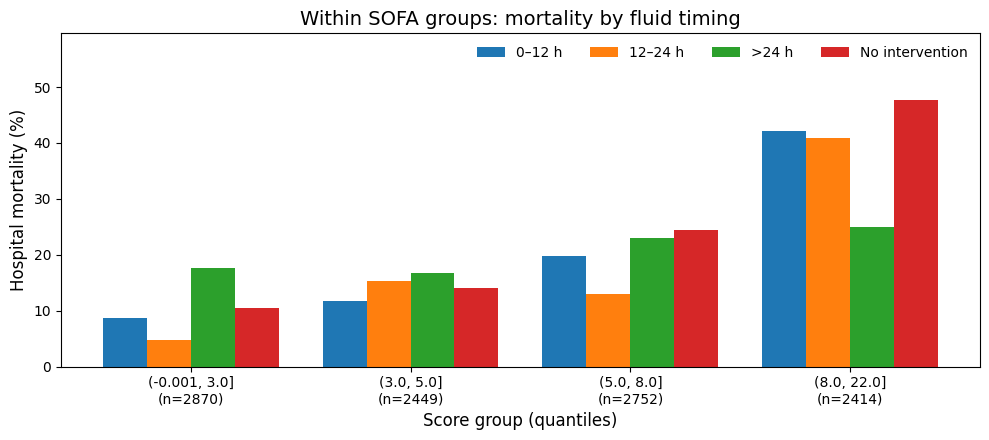

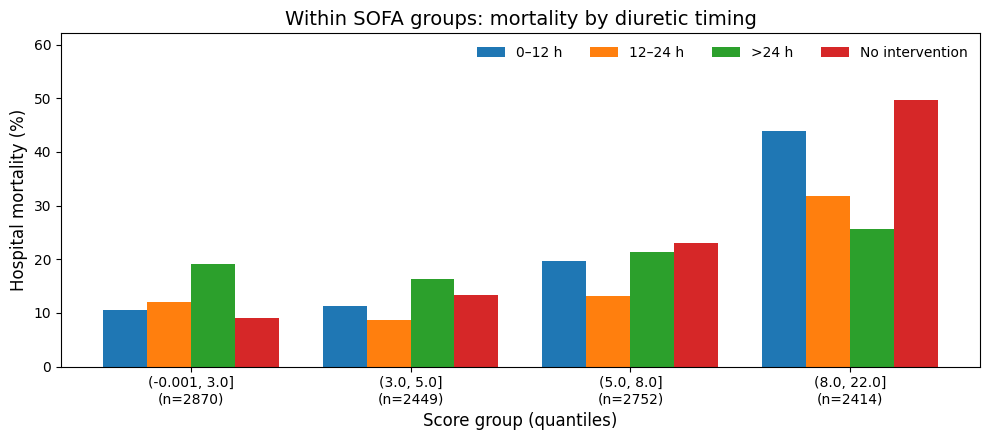

In [86]:
fig1 = plot_mortality_by_timing_within_score_bins(
    stats_sofa_vaso,
    score_bin_col="sofa_bin",
    timing_col="vaso_timing",
    title="Within SOFA groups: mortality by vasopressor timing"
)
plt.show()

fig2 = plot_mortality_by_timing_within_score_bins(
    stats_sofa_fluid,
    score_bin_col="sofa_bin",
    timing_col="fluid_timing",
    title="Within SOFA groups: mortality by fluid timing"
)
plt.show()

fig3 = plot_mortality_by_timing_within_score_bins(
    stats_sofa_diur,
    score_bin_col="sofa_bin",
    timing_col="diuretic_timing",
    title="Within SOFA groups: mortality by diuretic timing"
)
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


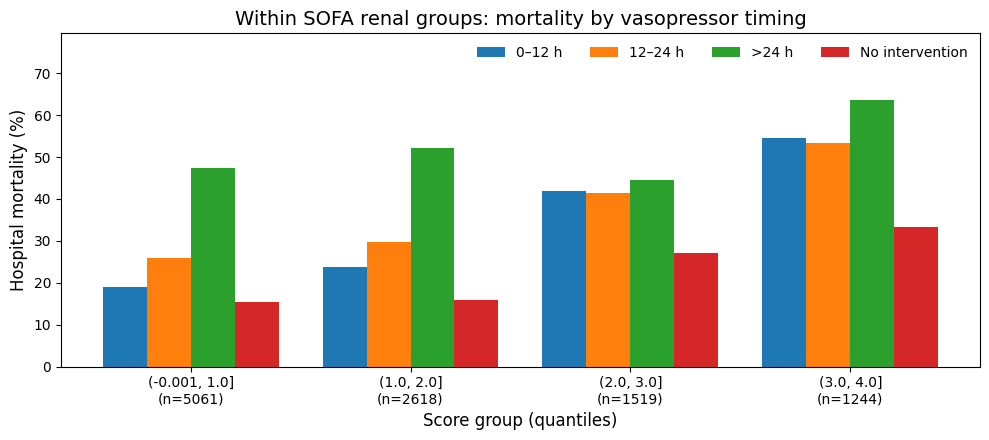

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


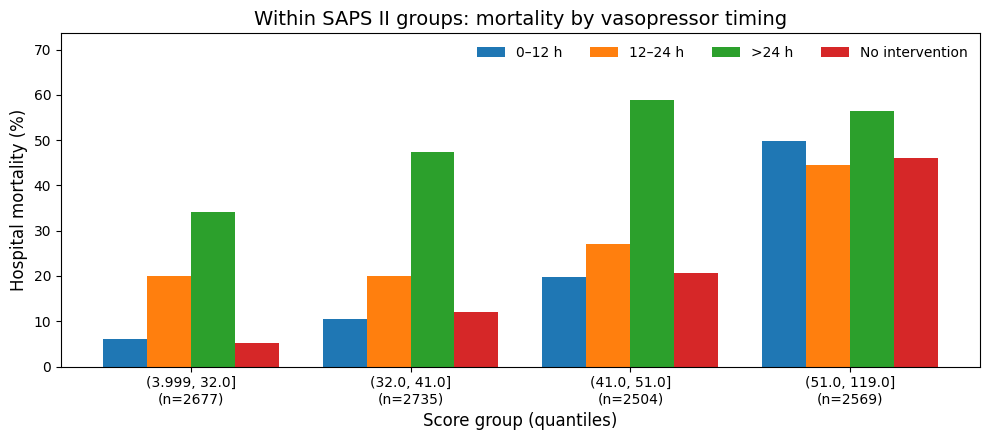

In [87]:
stats_renal_vaso = score_group_timing_stats(df4, "sofa_renal_bin", "vaso_timing")
plot_mortality_by_timing_within_score_bins(stats_renal_vaso, "sofa_renal_bin", "vaso_timing",
                                           "Within SOFA renal groups: mortality by vasopressor timing"); plt.show()

stats_saps_vaso = score_group_timing_stats(df4, "sapsii_bin", "vaso_timing")
plot_mortality_by_timing_within_score_bins(stats_saps_vaso, "sapsii_bin", "vaso_timing",
                                           "Within SAPS II groups: mortality by vasopressor timing"); plt.show()


In [ ]:
import pandas as pd
import numpy as np
from src.db import q

def first_intervention_timing(
    df,
    patterns,
    label,
):
    """
    Adds two columns:
      - first_<label>_hours
      - first_<label>_timing  ∈ {0–12 h, 12–24 h, >24 h, No intervention}
    """

    where = " OR ".join([f"LOWER(di.label) LIKE '{p}'" for p in patterns])

    ev = q(f"""
        SELECT ie.icustay_id, ie.starttime
        FROM inputevents_mv ie
        JOIN d_items di ON ie.itemid = di.itemid
        WHERE {where}
    """)

    ev = ev.merge(
        df[["icustay_id", "intime"]],
        on="icustay_id",
        how="inner"
    ).dropna(subset=["starttime", "intime"])

    ev["hours_since_icu"] = (
        ev["starttime"] - ev["intime"]
    ).dt.total_seconds() / 3600

    ev = ev[ev["hours_since_icu"] >= 0]

    first_ev = (
        ev.sort_values(["icustay_id", "hours_since_icu"])
          .groupby("icustay_id", as_index=False)
          .first()[["icustay_id", "hours_since_icu"]]
    )

    out = df.merge(first_ev, on="icustay_id", how="left")

    timing_col = f"first_{label}_timing"
    hours_col = f"first_{label}_hours"

    out[hours_col] = out["hours_since_icu"]

    out[timing_col] = np.select(
        [
            out[hours_col].between(0, 12, inclusive="left"),
            out[hours_col].between(12, 24, inclusive="left"),
            out[hours_col] > 24,
            out[hours_col].isna(),
        ],
        [
            "0–12 h",
            "12–24 h",
            ">24 h",
            "No intervention",
        ],
        default="Other",
    )

    out[timing_col] = pd.Categorical(
        out[timing_col],
        categories=["0–12 h", "12–24 h", ">24 h", "No intervention"],
        ordered=True
    )

    return out.drop(columns=["hours_since_icu"])


C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


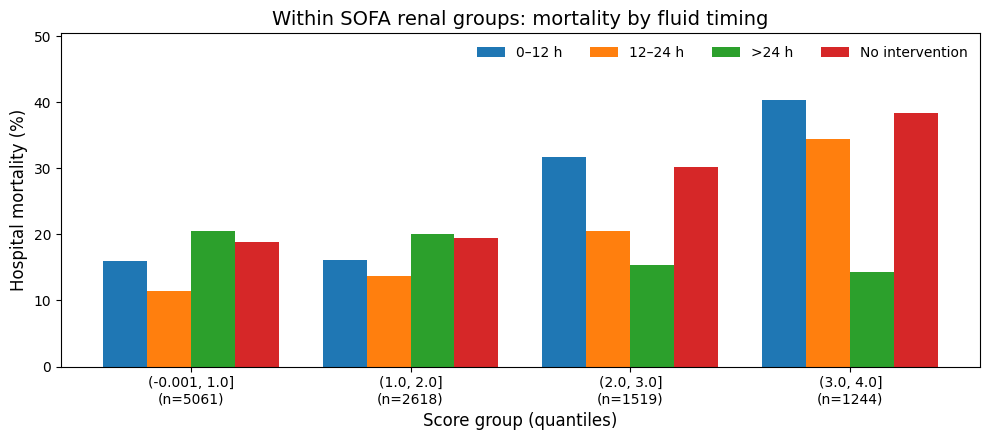

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


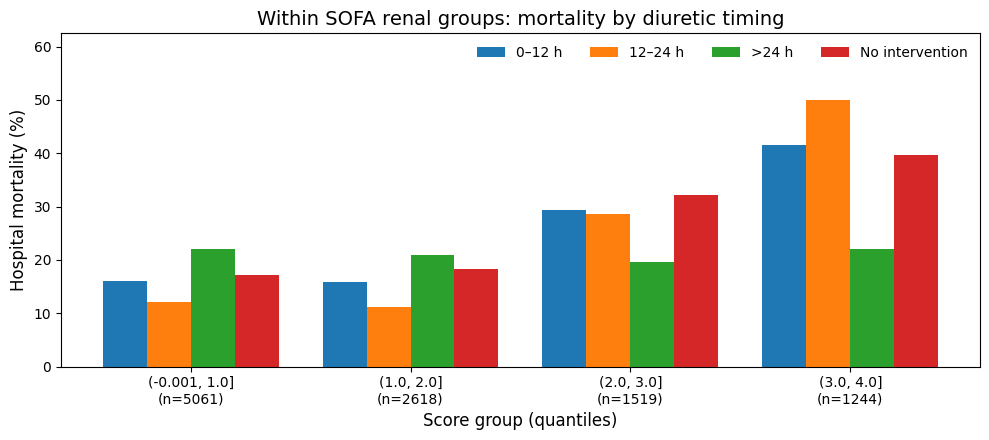

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


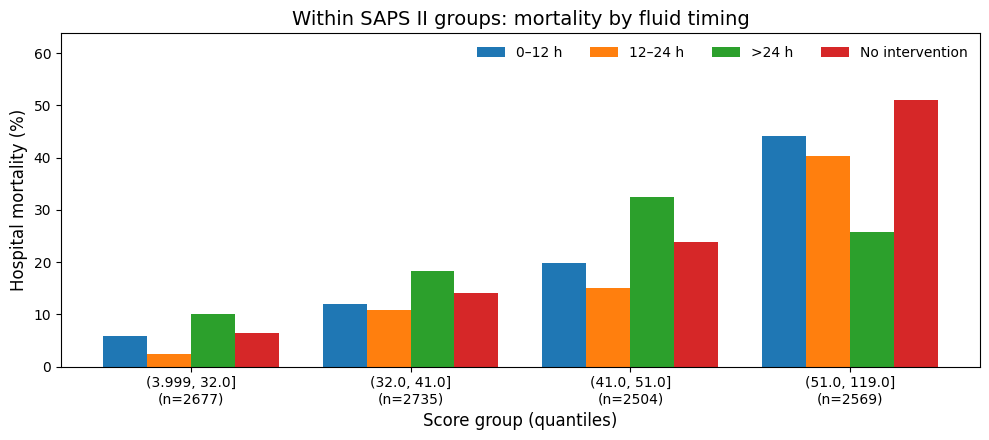

C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([score_bin_col, timing_col])
C:\Users\Simon\AppData\Local\Temp\ipykernel_16072\1865866853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg["bin_total"] = agg.groupby(score_bin_col)["n"].transform("sum")


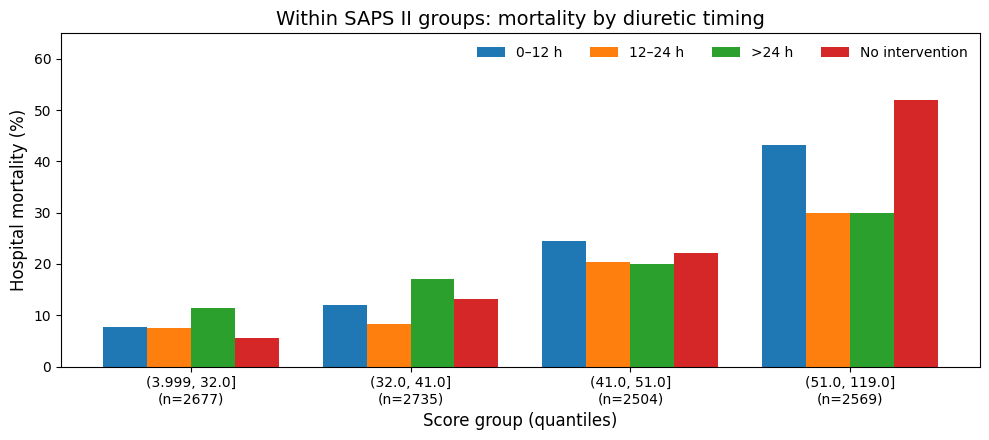

In [88]:
# --- SOFA renal bins: Fluids + Diuretics
stats_renal_fluid = score_group_timing_stats(df4, "sofa_renal_bin", "fluid_timing")
plot_mortality_by_timing_within_score_bins(
    stats_renal_fluid,
    "sofa_renal_bin",
    "fluid_timing",
    "Within SOFA renal groups: mortality by fluid timing"
); plt.show()

stats_renal_diur = score_group_timing_stats(df4, "sofa_renal_bin", "diuretic_timing")
plot_mortality_by_timing_within_score_bins(
    stats_renal_diur,
    "sofa_renal_bin",
    "diuretic_timing",
    "Within SOFA renal groups: mortality by diuretic timing"
); plt.show()


# --- SAPS II bins: Fluids + Diuretics
stats_saps_fluid = score_group_timing_stats(df4, "sapsii_bin", "fluid_timing")
plot_mortality_by_timing_within_score_bins(
    stats_saps_fluid,
    "sapsii_bin",
    "fluid_timing",
    "Within SAPS II groups: mortality by fluid timing"
); plt.show()

stats_saps_diur = score_group_timing_stats(df4, "sapsii_bin", "diuretic_timing")
plot_mortality_by_timing_within_score_bins(
    stats_saps_diur,
    "sapsii_bin",
    "diuretic_timing",
    "Within SAPS II groups: mortality by diuretic timing"
); plt.show()


In [98]:
def mean_scores_within_bins(
    df,
    score_bin_col,
    timing_col,
    score_cols=("sofa", "sofa_renal", "sapsii"),
):
    rows = []

    for b in df[score_bin_col].dropna().unique():
        sub_bin = df[df[score_bin_col] == b]

        for t in ["0–12 h", "12–24 h", ">24 h"]:
            sub = sub_bin[sub_bin[timing_col] == t]
            if sub.empty:
                continue

            row = {
                "Score bin": str(b),
                "Timing": t,
                "n": len(sub),
            }

            for sc in score_cols:
                med = sub[sc].mean()
                q1 = sub[sc].quantile(0.25)
                q3 = sub[sc].quantile(0.75)
                row[f"{sc} median (IQR)"] = f"{med:.1f} ({q1:.1f}–{q3:.1f})"

            rows.append(row)

    return pd.DataFrame(rows)


In [100]:
mean_sofa_vaso = mean_scores_within_bins(
    df4,
    score_bin_col="sofa_bin",
    timing_col="vaso_timing",
)

mean_sofa_vaso


,Score bin,Timing,n,sofa median (IQR),sofa_renal median (IQR),sapsii median (IQR)
0,"(5.0, 8.0]",0–12 h,437,7.0 (6.0–8.0),1.7 (1.0–2.0),45.1 (38.0–52.0)
1,"(5.0, 8.0]",12–24 h,44,7.3 (6.8–8.0),1.6 (1.0–3.0),48.0 (43.2–53.2)
2,"(5.0, 8.0]",>24 h,108,6.9 (6.0–8.0),1.8 (1.0–3.0),47.9 (38.8–57.0)
3,"(3.0, 5.0]",0–12 h,183,4.6 (4.0–5.0),1.0 (0.5–1.0),38.5 (32.0–46.0)
4,"(3.0, 5.0]",12–24 h,18,4.5 (4.0–5.0),1.2 (0.0–2.0),43.3 (34.2–56.8)
5,"(3.0, 5.0]",>24 h,78,4.6 (4.0–5.0),1.6 (1.0–3.0),38.5 (31.2–44.0)
6,"(-0.001, 3.0]",0–12 h,76,2.4 (2.0–3.0),0.7 (0.0–1.0),37.2 (32.0–43.0)
7,"(-0.001, 3.0]",12–24 h,6,2.5 (2.0–3.0),0.8 (1.0–1.0),37.8 (36.2–38.5)
8,"(-0.001, 3.0]",>24 h,101,2.1 (2.0–3.0),0.7 (0.0–1.0),34.0 (29.0–40.0)
9,"(8.0, 22.0]",0–12 h,723,12.1 (10.0–14.0),2.5 (1.5–4.0),59.6 (49.0–70.0)


use those valuesto show in graphik

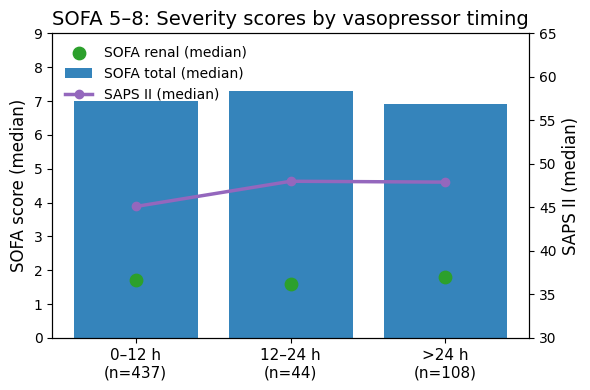

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- DataFrame direkt aus deinen Werten
plot_df = pd.DataFrame({
    "Timing": ["0–12 h", "12–24 h", ">24 h"],
    "n": [437, 44, 108],
    "sofa_median": [7.0, 7.3, 6.9],
    "sofa_renal_median": [1.7, 1.6, 1.8],
    "sapsii_median": [45.1, 48.0, 47.9],
})

x = np.arange(len(plot_df))

fig, ax1 = plt.subplots(figsize=(6, 4))

# --- SOFA total (bars)
ax1.bar(
    x,
    plot_df["sofa_median"],
    color="#1f77b4",
    alpha=0.9,
    label="SOFA total (median)"
)

# --- SOFA renal (points)
ax1.scatter(
    x,
    plot_df["sofa_renal_median"],
    color="#2ca02c",
    s=80,
    zorder=3,
    label="SOFA renal (median)"
)

ax1.set_ylabel("SOFA score (median)", fontsize=12)
ax1.set_ylim(0, 9)

# --- SAPS II (line, second axis)
ax2 = ax1.twinx()
ax2.plot(
    x,
    plot_df["sapsii_median"],
    color="#9467bd",
    marker="o",
    linewidth=2.5,
    label="SAPS II (median)"
)
ax2.set_ylabel("SAPS II (median)", fontsize=12)
ax2.set_ylim(30, 65)

# --- x labels with n
ax1.set_xticks(x)
ax1.set_xticklabels(
    [f"{t}\n(n={n})" for t, n in zip(plot_df["Timing"], plot_df["n"])],
    fontsize=11
)

# --- title
ax1.set_title(
    "SOFA 5–8: Severity scores by vasopressor timing",
    fontsize=14
)

# --- combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    frameon=False,
    loc="upper left"
)

plt.tight_layout()
plt.show()


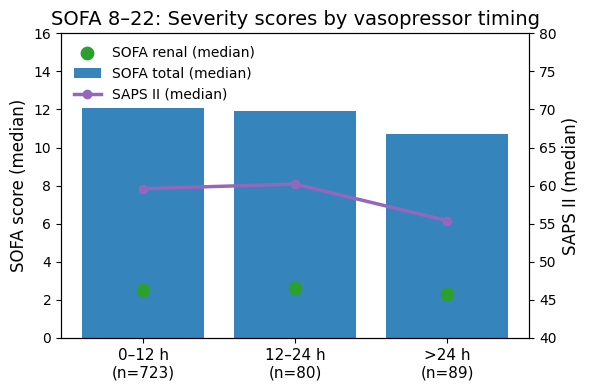

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Daten für SOFA 8–22
plot_df = pd.DataFrame({
    "Timing": ["0–12 h", "12–24 h", ">24 h"],
    "n": [723, 80, 89],
    "sofa_median": [12.1, 11.9, 10.7],
    "sofa_renal_median": [2.5, 2.6, 2.3],
    "sapsii_median": [59.6, 60.2, 55.4],
})

x = np.arange(len(plot_df))

fig, ax1 = plt.subplots(figsize=(6, 4))

# --- SOFA total (bars)
ax1.bar(
    x,
    plot_df["sofa_median"],
    color="#1f77b4",
    alpha=0.9,
    label="SOFA total (median)"
)

# --- SOFA renal (points)
ax1.scatter(
    x,
    plot_df["sofa_renal_median"],
    color="#2ca02c",
    s=80,
    zorder=3,
    label="SOFA renal (median)"
)

ax1.set_ylabel("SOFA score (median)", fontsize=12)
ax1.set_ylim(0, 16)

# --- SAPS II (line, second axis)
ax2 = ax1.twinx()
ax2.plot(
    x,
    plot_df["sapsii_median"],
    color="#9467bd",
    marker="o",
    linewidth=2.5,
    label="SAPS II (median)"
)
ax2.set_ylabel("SAPS II (median)", fontsize=12)
ax2.set_ylim(40, 80)

# --- x labels with n
ax1.set_xticks(x)
ax1.set_xticklabels(
    [f"{t}\n(n={n})" for t, n in zip(plot_df["Timing"], plot_df["n"])],
    fontsize=11
)

# --- title
ax1.set_title(
    "SOFA 8–22: Severity scores by vasopressor timing",
    fontsize=14
)

# --- combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    frameon=False,
    loc="upper left"
)

plt.tight_layout()
plt.show()


In [89]:
import numpy as np
import pandas as pd

df_test = df4.copy()

# Late vasopressor indicator
df_test["vaso_late"] = (
    df_test["vaso_timing"] == ">24 h"
).astype(int)

# Early (0–24 h) indicator
df_test["vaso_early"] = (
    df_test["vaso_timing"].isin(["0–12 h", "12–24 h"])
).astype(int)


In [90]:
from scipy.stats import chi2_contingency, fisher_exact

def test_late_vs_early_by_score_bin(
    df,
    score_bin_col,
    outcome_col="hospital_mortality"
):
    results = []

    for b in df[score_bin_col].dropna().unique():
        sub = df[df[score_bin_col] == b]

        # only early vs late
        sub = sub[sub["vaso_timing"].isin(["0–12 h", "12–24 h", ">24 h"])]

        if sub.empty:
            continue

        table = pd.crosstab(
            sub["vaso_late"],
            sub[outcome_col]
        )

        # ensure 2x2
        if table.shape != (2, 2):
            continue

        n_late = table.loc[1].sum()
        n_early = table.loc[0].sum()

        mort_late = table.loc[1, 1] / n_late if n_late > 0 else np.nan
        mort_early = table.loc[0, 1] / n_early if n_early > 0 else np.nan

        # choose test
        if (table.values < 5).any():
            _, p = fisher_exact(table)
            test = "Fisher"
        else:
            _, p, _, _ = chi2_contingency(table)
            test = "Chi-square"

        results.append({
            "Score bin": str(b),
            "n early (≤24h)": n_early,
            "n late (>24h)": n_late,
            "Mortality early": mort_early * 100,
            "Mortality late": mort_late * 100,
            "Δ mortality (late−early)": (mort_late - mort_early) * 100,
            "p value": p,
            "Test": test,
        })

    return pd.DataFrame(results)


In [91]:
test_sofa_vaso = test_late_vs_early_by_score_bin(
    df_test,
    score_bin_col="sofa_bin"
)

test_sofa_vaso


,Score bin,n early (≤24h),n late (>24h),Mortality early,Mortality late,Δ mortality (late−early),p value,Test
0,"(5.0, 8.0]",481,108,16.424116,52.777778,36.353661,1.520401e-15,Chi-square
1,"(3.0, 5.0]",201,78,15.422886,50.000000,34.577114,5.713112e-09,Chi-square
2,"(-0.001, 3.0]",82,101,9.756098,41.584158,31.828061,3.514549e-06,Chi-square
3,"(8.0, 22.0]",803,89,44.209215,55.056180,10.846964,6.602299e-02,Chi-square


In [108]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests

def per_bin_effects(
    df,
    score_bin_col="sofa_bin",
    timing_col="vaso_timing",
    outcome_col="hospital_mortality",
    early_levels=("0–12 h", "12–24 h"),
    late_level=">24 h",
):
    rows = []

    bins = [b for b in df[score_bin_col].dropna().unique()]
    bins = sorted(bins, key=lambda x: str(x))

    for b in bins:
        sub = df[df[score_bin_col] == b].copy()
        sub = sub[sub[timing_col].isin(list(early_levels) + [late_level])].copy()
        if sub.empty:
            continue

        sub["late"] = (sub[timing_col] == late_level).astype(int)
        y = pd.to_numeric(sub[outcome_col], errors="coerce").astype("Int64")

        # 2x2 counts: rows late(1)/early(0), cols death(1)/survive(0)
        tab = pd.crosstab(sub["late"], y).reindex(index=[0,1], columns=[0,1], fill_value=0)

        # cells
        early_surv = int(tab.loc[0, 0]); early_death = int(tab.loc[0, 1])
        late_surv  = int(tab.loc[1, 0]); late_death  = int(tab.loc[1, 1])

        n_early = early_surv + early_death
        n_late  = late_surv + late_death
        if n_early == 0 or n_late == 0:
            continue

        risk_early = early_death / n_early
        risk_late  = late_death / n_late
        rd = risk_late - risk_early

        # Effect sizes + CI via Table2x2 (Woolf log-OR / log-RR; RD CI via normal approx not in Table2x2)
        t22 = Table2x2([[late_death, late_surv],[early_death, early_surv]])
        or_ = t22.oddsratio
        or_ci = t22.oddsratio_confint()     # 95% CI
        rr_ = t22.riskratio
        rr_ci = t22.riskratio_confint()

        # RD 95% CI (Newcombe-style is best; statsmodels has for 2 indep proportions)
        from statsmodels.stats.proportion import confint_proportions_2indep
        rd_ci = confint_proportions_2indep(
            late_death, n_late,
            early_death, n_early,
            method="newcomb"
        )

        # p-value: use Fisher if any expected <5 else chi-square
        chi2_ok = True
        try:
            _, p_chi, _, expected = chi2_contingency([[late_death, late_surv],[early_death, early_surv]])
            if (expected < 5).any():
                chi2_ok = False
        except:
            chi2_ok = False

        if chi2_ok:
            p = p_chi
            test = "Chi-square"
        else:
            _, p = fisher_exact([[late_death, late_surv],[early_death, early_surv]])
            test = "Fisher exact"

        rows.append({
            "Score bin": str(b),
            "early_death": early_death, "early_surv": early_surv, "n_early": n_early,
            "late_death": late_death, "late_surv": late_surv, "n_late": n_late,
            "risk_early_%": 100*risk_early,
            "risk_late_%": 100*risk_late,
            "RD_%": 100*rd,
            "RD_CI_low_%": 100*rd_ci[0],
            "RD_CI_high_%": 100*rd_ci[1],
            "RR": rr_, "RR_CI_low": rr_ci[0], "RR_CI_high": rr_ci[1],
            "OR": or_, "OR_CI_low": or_ci[0], "OR_CI_high": or_ci[1],
            "p": p,
            "test": test
        })

    res = pd.DataFrame(rows)

    # multiple-testing correction across bins (FDR/BH)
    if not res.empty:
        res["p_fdr_bh"] = multipletests(res["p"].values, method="fdr_bh")[1]

    # nice ordering for display
    return res.sort_values("Score bin").reset_index(drop=True)

res = per_bin_effects(df_test, score_bin_col="sofa_bin", timing_col="vaso_timing")
res


,Score bin,early_death,early_surv,n_early,late_death,late_surv,n_late,risk_early_%,risk_late_%,RD_%,...,RD_CI_high_%,RR,RR_CI_low,RR_CI_high,OR,OR_CI_low,OR_CI_high,p,test,p_fdr_bh
0,"(-0.001, 3.0]",8,74,82,42,59,101,9.756098,41.584158,31.828061,...,42.662439,4.262376,2.121539,8.563524,6.584746,2.871677,15.098799,3.514549e-06,Chi-square,4.686066e-06
1,"(3.0, 5.0]",31,170,201,39,39,78,15.422886,50.000000,34.577114,...,46.246673,3.241935,2.189495,4.800259,5.483871,3.051739,9.854329,5.713112e-09,Chi-square,1.142622e-08
2,"(5.0, 8.0]",79,402,481,57,51,108,16.424116,52.777778,36.353661,...,46.003167,3.213432,2.455050,4.206084,5.687267,3.632833,8.903523,1.520401e-15,Chi-square,6.081604e-15
3,"(8.0, 22.0]",355,448,803,49,40,89,44.209215,55.056180,10.846964,...,21.325140,1.245355,1.016399,1.525886,1.545915,0.995367,2.400979,6.602299e-02,Chi-square,6.602299e-02


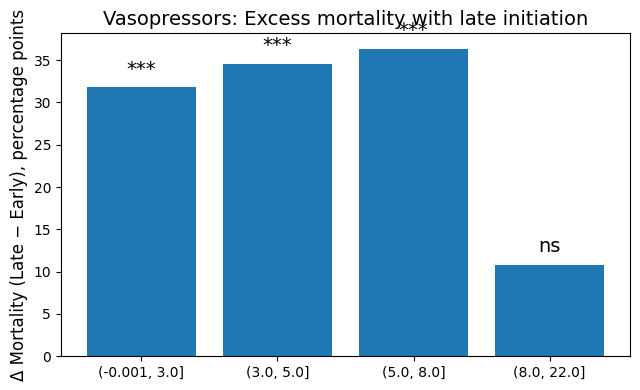

In [106]:
import numpy as np
import matplotlib.pyplot as plt

res = test_sofa_vaso.copy().sort_values("Score bin")

fig, ax = plt.subplots(figsize=(6.5, 4))

ax.bar(res["Score bin"], res["Δ mortality (late−early)"])

# p-value Sterne
def stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "ns"

for i, row in res.reset_index(drop=True).iterrows():
    ax.text(i, row["Δ mortality (late−early)"] + 1.0,
            stars(row["p value"]),
            ha="center", va="bottom", fontsize=14)

ax.set_ylabel("Δ Mortality (Late − Early), percentage points", fontsize=12)
ax.set_title("Vasopressors: Excess mortality with late initiation", fontsize=14)
ax.tick_params(axis="x", labelrotation=0)
plt.tight_layout()
plt.show()



In [ ]:
test_renal_vaso = test_late_vs_early_by_score_bin(
    df_test,
    score_bin_col="sofa_renal_bin"
)

test_saps_vaso = test_late_vs_early_by_score_bin(
    df_test,
    score_bin_col="sapsii_bin"
)
test_renal_vaso_2 = test_late

test_renal_vaso, test_saps_vaso


(       Score bin  n early (≤24h)  n late (>24h)  Mortality early  \
 0     (2.0, 3.0]             268             56        41.791045   
 1  (-0.001, 1.0]             677            209        19.645495   
 2     (1.0, 2.0]             365             67        24.109589   
 3     (3.0, 4.0]             257             44        54.474708   
 
    Mortality late  Δ mortality (late−early)       p value        Test  
 0       44.642857                  2.851812  8.070907e-01  Chi-square  
 1       47.368421                 27.722926  3.306437e-15  Chi-square  
 2       52.238806                 28.129217  5.558790e-06  Chi-square  
 3       63.636364                  9.161655  3.337978e-01  Chi-square  ,
        Score bin  n early (≤24h)  n late (>24h)  Mortality early  \
 0  (51.0, 119.0]             704            108        49.147727   
 1  (3.999, 32.0]             157             85         7.006369   
 2   (41.0, 51.0]             407             90        20.393120   
 3   (32.0,

In [93]:
import statsmodels.formula.api as smf

# nur Patienten mit Vasopressoren
df_lr = df_test[df_test["vaso_timing"].isin(["0–12 h", "12–24 h", ">24 h"])].copy()

df_lr["vaso_late"] = (df_lr["vaso_timing"] == ">24 h").astype(int)

model = smf.logit(
    "hospital_mortality ~ vaso_late + sofa + vaso_late:sofa",
    data=df_lr
).fit()

model.summary()


Optimization terminated successfully.
         Current function value: 0.570069
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     hospital_mortality   No. Observations:                 1943
Model:                          Logit   Df Residuals:                     1939
Method:                           MLE   Df Model:                            3
Date:                Tue, 27 Jan 2026   Pseudo R-squ.:                  0.1104
Time:                        19:33:30   Log-Likelihood:                -1107.6
converged:                       True   LL-Null:                       -1245.1
Covariance Type:            nonrobust   LLR p-value:                 2.618e-59
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.0194      0.177    -17.040      0.000      -3.367      -2.672
vaso_late          2.5973      0.281      9.248      0.000       2.047       3.148
sofa               0.2271      0.017     13.601      0.000       0.194       0.260
vaso_late:sofa    -0.1590      0.036     -4.437      0.000      -0.229      -0.089
==================================================================================
"""

In [109]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

def fmt_p(p):
    if pd.isna(p):
        return ""
    if p < 0.001:
        return "<0.001"
    return f"{p:.3f}"

def choose_test_2x2(tab):
    # tab is 2x2 numpy array [[a,b],[c,d]]
    try:
        _, p_chi, _, expected = chi2_contingency(tab)
        if (expected < 5).any():
            _, p = fisher_exact(tab)
            return p, "Fisher exact"
        return p_chi, "Chi-square"
    except Exception:
        _, p = fisher_exact(tab)
        return p, "Fisher exact"


In [114]:
def stratified_binary_outcome_table(
    df,
    score_bin_col,
    timing_col,
    group_a_levels,
    group_b_levels,
    outcome_col="hospital_mortality",
    label_a="A",
    label_b="B",
):
    rows = []

    bins = df[score_bin_col].dropna().unique()
    bins = sorted(bins, key=lambda x: str(x))

    for b in bins:
        sub = df[df[score_bin_col] == b].copy()
        sub = sub[sub[timing_col].isin(list(group_a_levels) + list(group_b_levels))].copy()
        if sub.empty:
            continue

        sub["grp"] = np.where(sub[timing_col].isin(group_b_levels), "B", "A")
        y = pd.to_numeric(sub[outcome_col], errors="coerce").fillna(0).astype(int)

        n_a = int((sub["grp"] == "A").sum())
        n_b = int((sub["grp"] == "B").sum())
        if n_a == 0 or n_b == 0:
            continue

        deaths_a = int(y[sub["grp"] == "A"].sum())
        deaths_b = int(y[sub["grp"] == "B"].sum())

        mort_a = 100 * deaths_a / n_a
        mort_b = 100 * deaths_b / n_b
        delta = mort_b - mort_a  # percentage points

        alive_a = n_a - deaths_a
        alive_b = n_b - deaths_b
        tab = np.array([[alive_a, deaths_a], [alive_b, deaths_b]])

        p, test = choose_test_2x2(tab)

        rows.append({
            "Score bin": str(b),
            f"n {label_a}": n_a,
            f"n {label_b}": n_b,
            f"Mortality {label_a} (%)": mort_a,
            f"Mortality {label_b} (%)": mort_b,
            "Δ Mortality (pp)": delta,
            "p value": p,
            "Test": test,
        })

    out = pd.DataFrame(rows)

    # ---- Slide-friendly formatting
    if out.empty:
        return out

    for col in out.columns:
        if "Mortality" in col or col == "Δ Mortality (pp)":
            out[col] = out[col].astype(float).round(1)

    out["p value"] = out["p value"].map(fmt_p)

    return out


In [115]:
tab_early_vs_late = stratified_binary_outcome_table(
    df_test,                       # oder df4/df3, solange sofa_bin + vaso_timing + hospital_mortality drin ist
    score_bin_col="sofa_bin",
    timing_col="vaso_timing",
    group_a_levels=["0–12 h", "12–24 h"],   # Early
    group_b_levels=[">24 h"],              # Late
    label_a="Early (≤24h)",
    label_b="Late (>24h)",
)

tab_early_vs_late


,Score bin,n Early (≤24h),n Late (>24h),Mortality Early (≤24h) (%),Mortality Late (>24h) (%),Δ Mortality (pp),p value,Test
0,"(-0.001, 3.0]",82,101,9.8,41.6,31.8,<0.001,Chi-square
1,"(3.0, 5.0]",201,78,15.4,50.0,34.6,<0.001,Chi-square
2,"(5.0, 8.0]",481,108,16.4,52.8,36.4,<0.001,Chi-square
3,"(8.0, 22.0]",803,89,44.2,55.1,10.8,0.066,Chi-square


In [116]:
tab_late_vs_never = stratified_binary_outcome_table(
    df_test,
    score_bin_col="sofa_bin",
    timing_col="vaso_timing",
    group_a_levels=["No intervention"],
    group_b_levels=[">24 h"],
    label_a="Never",
    label_b="Late (>24h)",
)

tab_late_vs_never


,Score bin,n Never,n Late (>24h),Mortality Never (%),Mortality Late (>24h) (%),Δ Mortality (pp),p value,Test
0,"(-0.001, 3.0]",2687,101,8.6,41.6,32.9,<0.001,Chi-square
1,"(3.0, 5.0]",2170,78,11.7,50.0,38.3,<0.001,Chi-square
2,"(5.0, 8.0]",2163,108,21.8,52.8,31.0,<0.001,Chi-square
3,"(8.0, 22.0]",1522,89,44.5,55.1,10.5,0.068,Chi-square


In [123]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

def sofa_renal_late_vs_never(
    df,
    renal_bin_col="sofa_renal_bin",
    timing_col="vaso_timing",
    outcome_col="hospital_mortality",
):
    rows = []

    bins = sorted(df[renal_bin_col].dropna().unique(), key=lambda x: str(x))

    for b in bins:
        sub = df[df[renal_bin_col] == b].copy()
        sub = sub[sub[timing_col].isin(["No intervention", ">24 h"])].copy()
        if sub.empty:
            continue

        sub["grp"] = np.where(sub[timing_col] == ">24 h", "Late", "Never")
        y = pd.to_numeric(sub[outcome_col], errors="coerce").fillna(0).astype(int)

        n_never = int((sub["grp"] == "Never").sum())
        n_late  = int((sub["grp"] == "Late").sum())
        if n_never == 0 or n_late == 0:
            continue

        d_never = int(y[sub["grp"] == "Never"].sum())
        d_late  = int(y[sub["grp"] == "Late"].sum())

        mort_never = 100 * d_never / n_never
        mort_late  = 100 * d_late  / n_late
        delta = mort_late - mort_never

        # 2x2 table: rows Never/Late, cols Alive/Dead
        tab = np.array([
            [n_never - d_never, d_never],
            [n_late  - d_late,  d_late],
        ])

        # automatic test choice
        try:
            _, p_chi, _, exp = chi2_contingency(tab)
            if (exp < 5).any():
                _, p = fisher_exact(tab)
                test = "Fisher exact"
            else:
                p = p_chi
                test = "Chi-square"
        except:
            _, p = fisher_exact(tab)
            test = "Fisher exact"

        rows.append({
            "SOFA renal score bin": str(b),
            "Never n": n_never,
            "Late n": n_late,
            "Mortality Never (%)": round(mort_never, 1),
            "Mortality Late (%)": round(mort_late, 1),
            "Δ Mortality (pp)": round(delta, 1),
            "p value": "<0.001" if p < 0.001 else f"{p:.3f}",
            "Test": test,
        })

    return pd.DataFrame(rows)


In [124]:
tab_renal_late_vs_never = sofa_renal_late_vs_never(df_test)
tab_renal_late_vs_never


,SOFA renal score bin,Never n,Late n,Mortality Never (%),Mortality Late (%),Δ Mortality (pp),p value,Test
0,"(-0.001, 1.0]",4175,209,15.5,47.4,31.8,<0.001,Chi-square
1,"(1.0, 2.0]",2186,67,16.0,52.2,36.3,<0.001,Chi-square
2,"(2.0, 3.0]",1195,56,27.1,44.6,17.5,0.007,Chi-square
3,"(3.0, 4.0]",943,44,33.2,63.6,30.4,<0.001,Chi-square


In [121]:
from pandas.io.formats.style import Styler

def slide_table(df):
    return (
        df
        .drop(columns=["Test"], errors="ignore")
        .style
        .format({
            "Mortality Early (%)": "{:.1f}",
            "Mortality Late (%)": "{:.1f}",
            "Δ Mortality (pp)": "{:+.1f}",
        })
        .set_table_styles([
            {"selector": "th", "props": [("font-size", "12pt"), ("text-align", "center")]},
            {"selector": "td", "props": [("font-size", "12pt"), ("text-align", "center")]},
        ])
    )

slide_table(tab_early_vs_late)



,Score bin,n Early (≤24h),n Late (>24h),Mortality Early (≤24h) (%),Mortality Late (>24h) (%),Δ Mortality (pp),p value
0,"(-0.001, 3.0]",82,101,9.800000,41.600000,+31.8,<0.001
1,"(3.0, 5.0]",201,78,15.400000,50.000000,+34.6,<0.001
2,"(5.0, 8.0]",481,108,16.400000,52.800000,+36.4,<0.001
3,"(8.0, 22.0]",803,89,44.200000,55.100000,+10.8,0.066


In [122]:
print(
    tab_early_vs_late
    .drop(columns=["Test"], errors="ignore")
    .to_latex(
        index=False,
        float_format="%.1f",
        caption="Vasopressor timing and hospital mortality stratified by SOFA score",
        label="tab:vaso_sofa"
    )
)


\begin{table}
\caption{Vasopressor timing and hospital mortality stratified by SOFA score}
\label{tab:vaso_sofa}
\begin{tabular}{lrrrrrl}
\toprule
Score bin & n Early (≤24h) & n Late (>24h) & Mortality Early (≤24h) (%) & Mortality Late (>24h) (%) & Δ Mortality (pp) & p value \\
\midrule
(-0.001, 3.0] & 82 & 101 & 9.8 & 41.6 & 31.8 & <0.001 \\
(3.0, 5.0] & 201 & 78 & 15.4 & 50.0 & 34.6 & <0.001 \\
(5.0, 8.0] & 481 & 108 & 16.4 & 52.8 & 36.4 & <0.001 \\
(8.0, 22.0] & 803 & 89 & 44.2 & 55.1 & 10.8 & 0.066 \\
\bottomrule
\end{tabular}
\end{table}

